In [1]:
# =============================================================================
# NOTEBOOK SETUP - Two Population Delay Sweep Execution
# =============================================================================
import os
import sys
from pathlib import Path

# Robust directory setup
if Path.cwd().name == 'two_populations':
    os.chdir("../../")

from src.two_populations.helpers.logger import setup_logger

logger = setup_logger(
    experiment_name="test_delays",
    console_level="DEBUG",
    log_to_file=False
)


logger.info(f"Working directory: {Path.cwd()}")
logger.info(f"Python path: {sys.path[0]}")

INFO     | __main__:<module>:21 - Working directory: /home/ubuntu-deduce/Projects/izhikevich
INFO     | __main__:<module>:22 - Python path: /home/ubuntu-deduce/.asdf/installs/python/3.10.13/lib/python310.zip


In [4]:
from src.two_populations.model import IzhikevichNetwork
import numpy as np
from src.two_populations.model import IzhikevichNetwork
from src.two_populations.metrics import analyze_simulation_results, print_network_statistics_table
from src.two_populations.plots.dashboard_plots import plot_connectivity_dashboard, plot_population_dashboard
from brian2 import * 

# =============================================================================
# SINGLE SIMULATION CONFIGURATION
# =============================================================================

k_factor = 40.0
noise_int = 5.0 #*0.9 #5.1*0.85
noise_inh_factor = 0.45 #5
intra_delay = 0.0
p_intra = 0.1
Ni = 200
Ne = 800
time = 3500

# Simulation parameters
SIM_CONFIG = {
    'dt_ms': 0.1,
    'T_ms': time,
    'warmup_ms': 500
}


# Network parameters
NETWORK_PARAMS = {
    'pop_A': {
        'Ne': Ne, 'Ni': Ni,
        'k_exc': k_factor, 'k_inh': k_factor*3.9,
        'noise_exc': 0.884131778925051, 
        'noise_inh': 0.6041873715553614,
        'p_intra': 0.1, 
        'delay': 0.0,
        'rate_hz':10.106089400313447,
        'stim_start_ms':500.0, 'stim_duration_ms': 100,
        'stim_base': 0.0, 
        'stim_elevated': 3.0
    }
}

# NETWORK_PARAMS = {
#     'pop_A': {
#         'Ne': Ne, 'Ni': Ni,
#         'k_exc': k_factor, 'k_inh': k_factor* 3.9,
#         'noise_exc': noise_int, 'noise_inh': noise_int*noise_inh_factor,
#         'p_intra': p_intra, 'delay': intra_delay,
#         'noise_type': 'gaussian',  # 'poisson', 'gaussian', 'step', 'none'
#         'step': True,
#         'stim_start_ms':500.0, 'stim_duration_ms': 250,
#         'stim_base': 0.2, 
#         'stim_elevated': 1.0
#     }
# }

logger.info("Simulation configured:")
logger.info(f"  Duration: {SIM_CONFIG['T_ms']}ms, dt: {SIM_CONFIG['dt_ms']}ms")

# =============================================================================
# RUN SINGLE SIMULATION
# =============================================================================

start_scope()

# Create network
network = IzhikevichNetwork(
    dt_val=SIM_CONFIG['dt_ms'],
    T_total=SIM_CONFIG['T_ms'],
    fixed_seed=100,
    variable_seed=200,
    trial=0
)


pop_A = network.create_population2(name='A', **NETWORK_PARAMS['pop_A'])
# Caso 1: Silencio + pulso de 50ms
# pop_A = network.create_population('A', **NETWORK_PARAMS['pop_A'])


# Setup monitors and run
network.setup_monitors(['A'], record_v_dt=0.5, sample_fraction=0.5)
results = network.run_simulation()

# Quick check
logger.info(f"\n{'='*50}")
logger.info("SIMULATION COMPLETED")
logger.info(f"{'='*50}")
logger.info(f"Population A: {len(results['A']['spike_times'])} spikes")
logger.info(f"Recording shape: {results['A']['potentials'].shape}")


# =============================================================================
# ANALYSIS WITH VALIDATION
# =============================================================================
from src.two_populations.metrics import analyze_simulation_results

# Analyze connectivity
results_dict = {
    'baseline': analyze_simulation_results(
        spike_mon_A = results['A']['spike_monitor'], 
        spike_mon_B = None,  
        N = Ne + Ni, 
        condition_name="test",
        warmup=SIM_CONFIG['warmup_ms'],
        state_monitors={'A': network.monitors['A']},
        delays=None, 
        signal_mode='lfp',
        T_total=SIM_CONFIG['T_ms']
    )
}

INFO       Simulation configured: [brian2]
INFO         Duration: 3500ms, dt: 0.1ms [brian2]
SUCCESS  | src.two_populations.model:__init__:45 - Network initialized with seeds: {'trial': 0, 'fixed_seed_A': 99, 'fixed_seed_B': 101, 'fixed_seed_common': 100, 'variable_common_current': 200, 'variable_A_current': 200, 'variable_B_current': 203}
INFO     | src.two_populations.model:_create_stimulus2:290 - Creating Poisson for A with seed state: 199
INFO     | src.two_populations.model:_create_stimulus2:352 - PoissonGroup A: 100 sources @ 10.106089400313447Hz → 80000 exc + 20000 inh synapses
INFO     | src.two_populations.model:create_population2:267 - Population A (PoissonInput): 800E/200I, 79872+20190 syn
INFO       
================================================== [brian2]
INFO       SIMULATION COMPLETED [brian2]
INFO       ================================================== [brian2]
INFO       Population A: 284948 spikes [brian2]
INFO       Recording shape: (500, 7000) [brian2]
INFO     

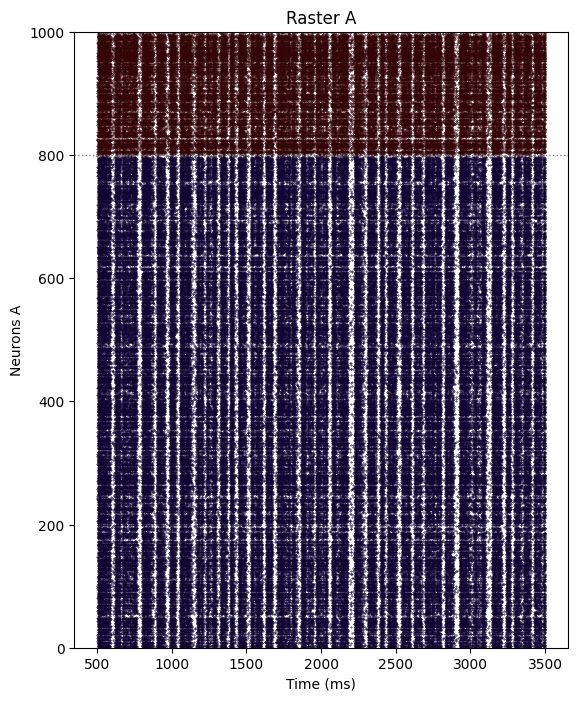

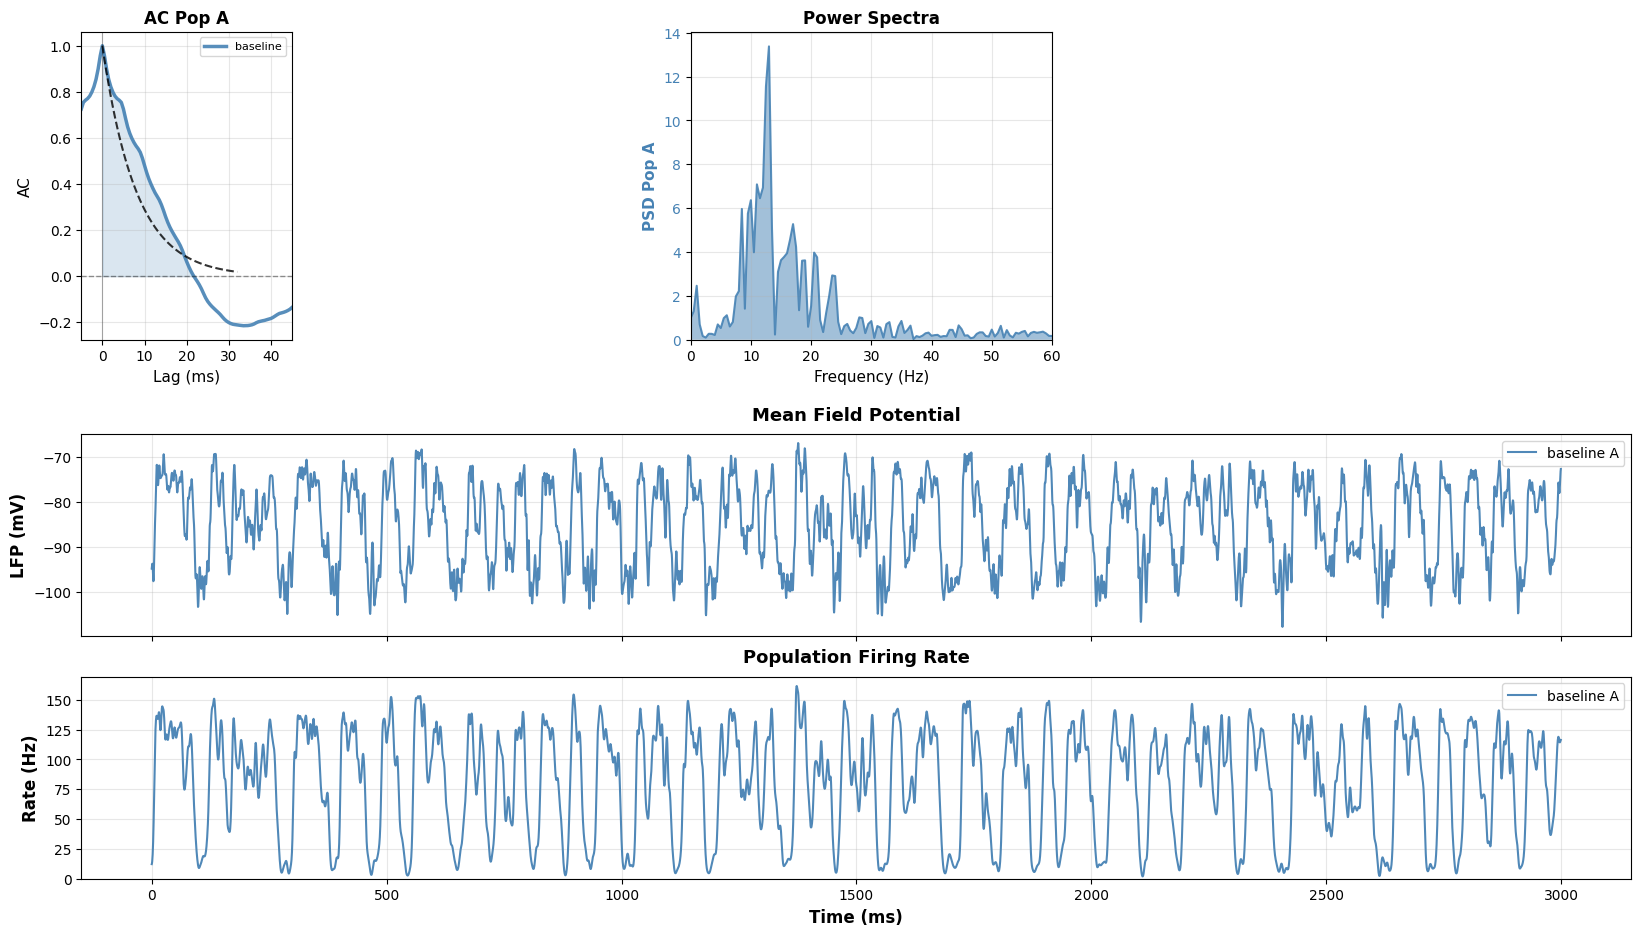

In [5]:
from src.two_populations.plots.basic_plots import plot_all_basic_analysis
from src.two_populations.plots.basic_plots import plot_raster_results

fig = plot_raster_results(results)

fig = plot_population_dashboard(results_dict)

In [4]:
results_dict['baseline']['time_series']['fr_A'].mean()

np.float64(36.666266666666665)

In [5]:
exc_mask = (results_dict['baseline']['spike_neurons_A'] < 800)

inh_spikes = results_dict['baseline']['spike_times_A'][~exc_mask]
exc_spikes = results_dict['baseline']['spike_times_A'][exc_mask]

warmup_mask = (inh_spikes > 500.0)
inh_spikes = inh_spikes[warmup_mask]

warmup_mask = (exc_spikes > 500.0)
exc_spikes = exc_spikes[warmup_mask]


np.shape(inh_spikes)[0]/3000.0 , np.shape(exc_spikes)[0]/3000.0, (np.shape(inh_spikes)[0]/3000.0 + np.shape(exc_spikes)[0]/3000.0)/2.0


(9.427666666666667, 27.237666666666666, 18.332666666666668)

ISI Excitatorias: media=29.10 ms, std=37.69 ms
ISI Inhibitorias: media=21.09 ms, std=25.34 ms
ISI < 4ms (Exc): 0.0%
ISI <4ms (Inh): 0.0%


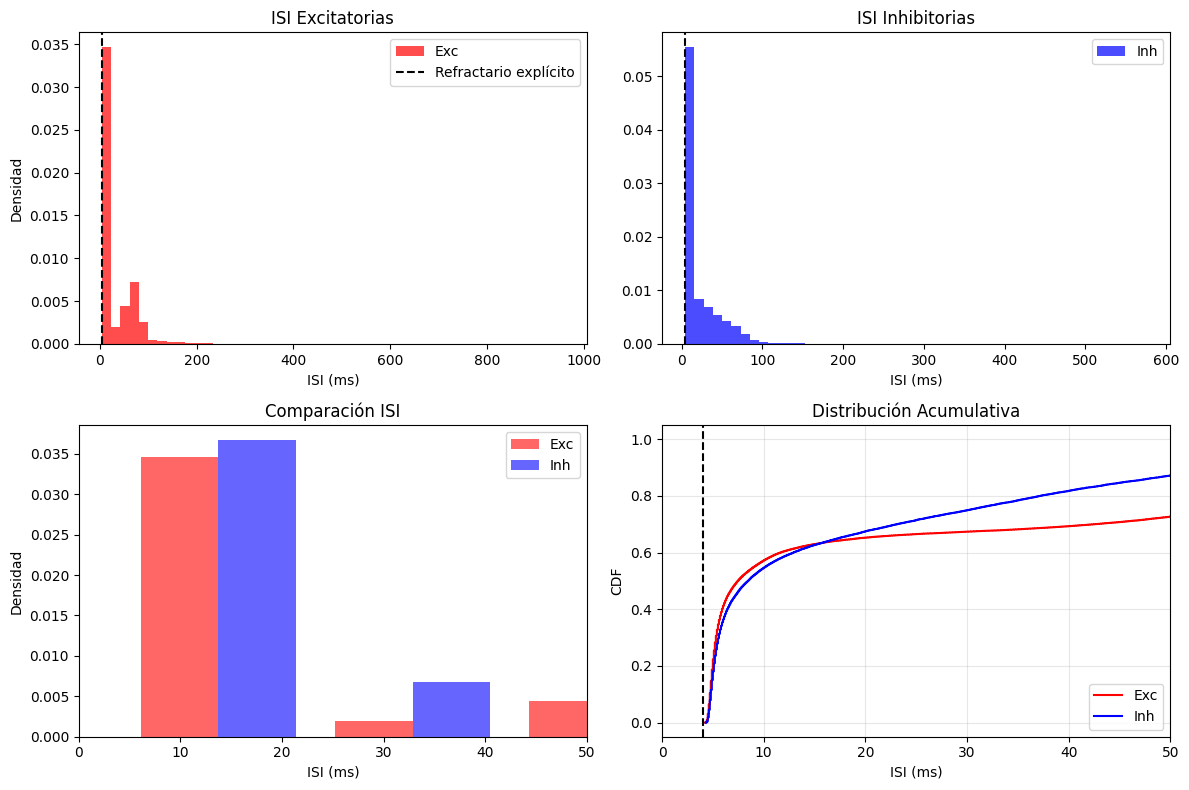

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from src.two_populations.metrics import analyze_ISI, estimate_intrinsic_refractoriness

# Uso:
isi_exc, isi_inh = analyze_ISI(results['A']['spike_monitor'], Ne, Ni, t_start=500*ms)

PERÍODO REFRACTARIO INTRÍNSECO (sin refractory explícito)

EXC:
  ISI mínimo:    4.20 ms
  ISI P1:        4.50 ms
  ISI P5:        4.60 ms
  ISI mediana:   7.50 ms

INH:
  ISI mínimo:    4.30 ms
  ISI P1:        4.50 ms
  ISI P5:        4.70 ms
  ISI mediana:   8.50 ms


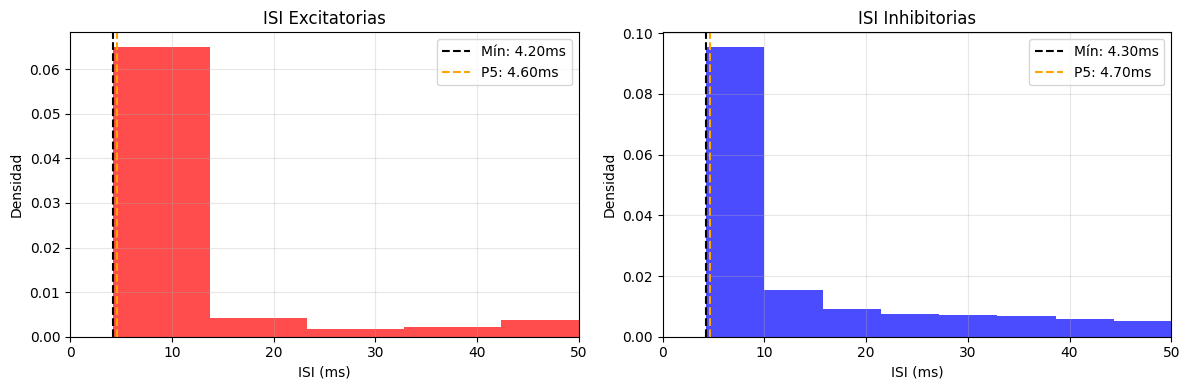

In [7]:
# 1. Corre simulación SIN refractory
# 2. Estima refractariedad intrínseca
intrinsic_results, _ = estimate_intrinsic_refractoriness(
    results['A']['spike_monitor'], Ne, Ni, t_start=500*ms
)

baseline: 500 monitored, 400 exc
  Plotting: [np.int64(174), np.int64(501), np.int64(329), np.int64(801), np.int64(926), np.int64(970)]


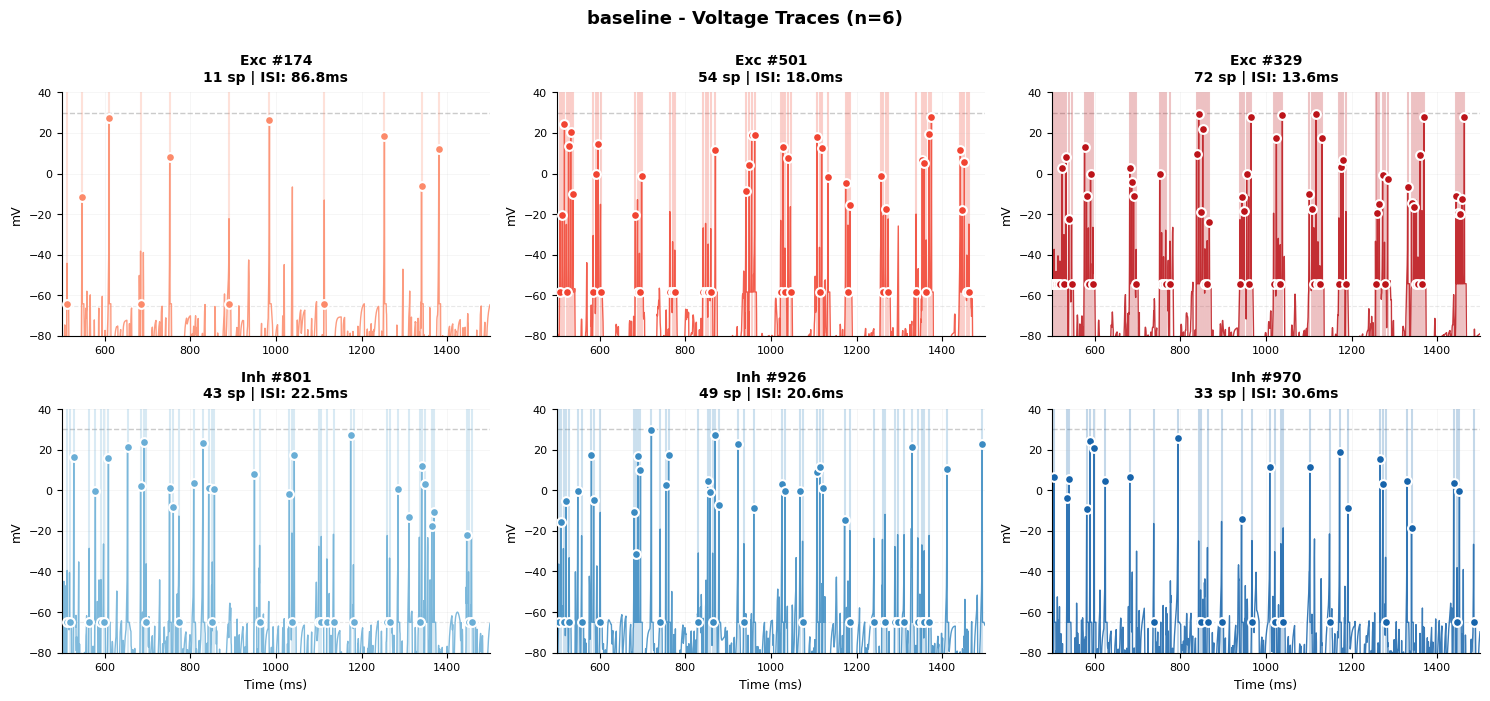

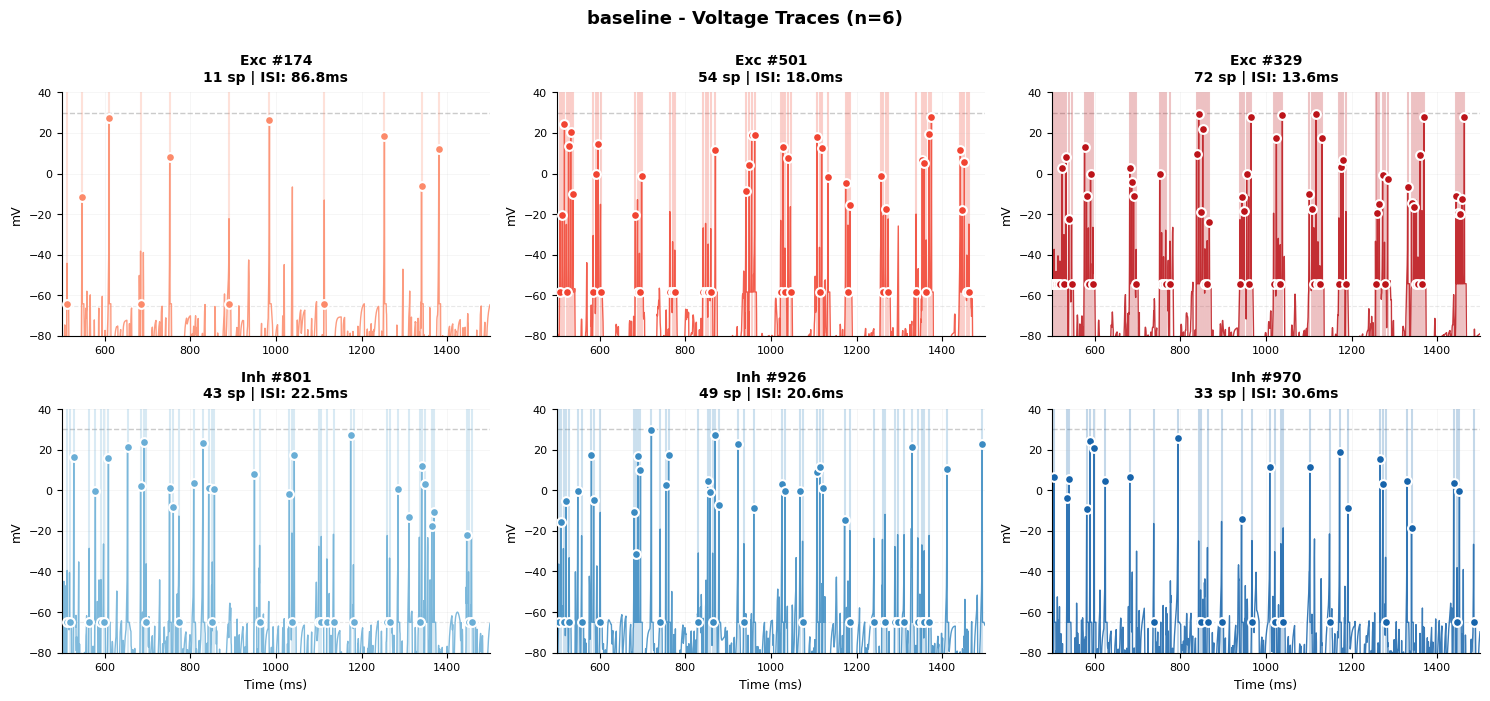

In [8]:
from src.two_populations.plots.basic_plots import plot_voltage_traces

plot_voltage_traces(results_dict, results, (500,1500) , 3 , 3, True, 3)

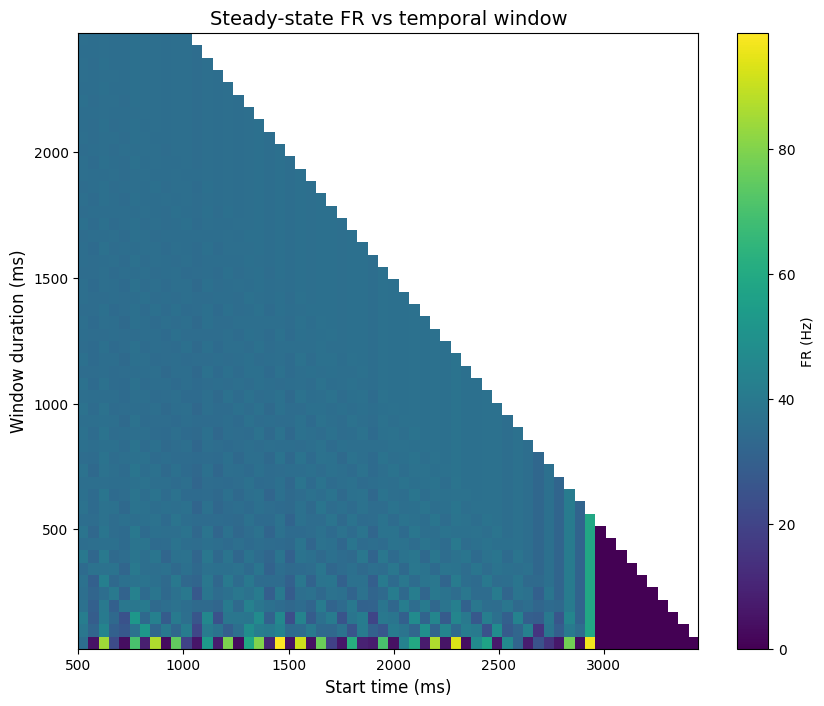

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter
from brian2 import ms

# =============================================================================
# CÁLCULO DE FR (necesario para heatmap)
# =============================================================================

def compute_steady_state_fr(results_dict, start_ms=1500, duration_ms=1000):
    """Calcula FR promedio en ventana temporal (para heatmap)"""
    fr_stats = {}
    
    for condition, results in results_dict.items():
        ts = results['time_series']
        time = ts['time_fr']
        mask = (time >= start_ms) & (time < start_ms + duration_ms)
        
        fr_A_mean = np.mean(ts['fr_A'][mask]) if np.any(mask) else 0.0
        
        fr_stats[condition] = {
            'fr_A': fr_A_mean,
            'window_start_ms': start_ms,
            'window_duration_ms': duration_ms,
            'n_samples': np.sum(mask)
        }
    
    return fr_stats


def compute_steady_state_fr_by_type(grouped, k_vals, n_trials, 
                                     start_ms=1500, duration_ms=500):
    """Calcula FR_exc, FR_inh, FR_total para cada k"""
    fr_exc_all, fr_inh_all, fr_total_all = [], [], []
    
    for k in k_vals:
        fr_exc_trials, fr_inh_trials, fr_tot_trials = [], [], []
        
        for trial in range(n_trials):
            data = grouped[k][trial]
            
            # Máscara temporal
            t_mask = (data['spike_times']/ms >= start_ms) & \
                     (data['spike_times']/ms < start_ms + duration_ms)
            
            spikes_in_window = data['spike_indices'][t_mask]
            Ne = data['Ne']
            Ni = data['Ni']
            
            # Contar por tipo
            n_exc = np.sum(spikes_in_window < Ne)
            n_inh = np.sum(spikes_in_window >= Ne)
            
            # FR en Hz
            window_s = duration_ms / 1000
            fr_exc_trials.append(n_exc / (Ne * window_s))
            fr_inh_trials.append(n_inh / (Ni * window_s))
            fr_tot_trials.append((n_exc + n_inh) / ((Ne + Ni) * window_s))
        
        fr_exc_all.append((np.mean(fr_exc_trials), np.std(fr_exc_trials)))
        fr_inh_all.append((np.mean(fr_inh_trials), np.std(fr_inh_trials)))
        fr_total_all.append((np.mean(fr_tot_trials), np.std(fr_tot_trials)))
    
    return {
        'exc': np.array(fr_exc_all),
        'inh': np.array(fr_inh_all),
        'total': np.array(fr_total_all)
    }


# Parámetros del grid
start_range = np.arange(500, 3500, 50)  # Inicio ventana (post-estímulo)
duration_range = np.arange(25, 2525, 50)  # Duración ventana

fr_grid = np.zeros((len(duration_range), len(start_range)))

for i, duration in enumerate(duration_range):
    for j, start in enumerate(start_range):
        # Verificar que no excede tiempo total
        if start + duration > 3500:  # Ajustar según T_total
            fr_grid[i, j] = np.nan
            continue
        
        fr_steady = compute_steady_state_fr(results_dict, start_ms=start, duration_ms=duration)
        fr_grid[i, j] = fr_steady['baseline']['fr_A']

# Plot
fig, ax = plt.subplots(figsize=(10, 8))
im = ax.imshow(fr_grid, aspect='auto', origin='lower', 
               extent=[start_range[0], start_range[-1], duration_range[0], duration_range[-1]],
               cmap='viridis')
ax.set_xlabel('Start time (ms)', fontsize=12)
ax.set_ylabel('Window duration (ms)', fontsize=12)
ax.set_title('Steady-state FR vs temporal window', fontsize=14)
plt.colorbar(im, ax=ax, label='FR (Hz)')
plt.show()

SUCCESS  | src.two_populations.model:__init__:45 - Network initialized with seeds: {'trial': 0, 'fixed_seed_A': 99, 'fixed_seed_B': 101, 'fixed_seed_common': 100, 'variable_common_current': 200, 'variable_A_current': 200, 'variable_B_current': 203}
INFO     | src.two_populations.model:_create_stimulus2:290 - Creating Poisson for A with seed state: 199
INFO     | src.two_populations.model:_create_stimulus2:352 - PoissonGroup A: 100 sources @ 10.106089400313447Hz → 80000 exc + 20000 inh synapses
INFO     | src.two_populations.model:create_population2:267 - Population A (PoissonInput): 800E/200I, 79872+20190 syn
INFO     | src.two_populations.metrics:analyze_simulation_results:562 - 
=== decay (lfp) ===
INFO     | src.two_populations.metrics:analyze_simulation_results:569 - Single population analysis
INFO     | src.two_populations.metrics:analyze_simulation_results:570 - Timescale A: 9.8ms
SUCCESS  | src.two_populations.model:__init__:45 - Network initialized with seeds: {'trial': 1, 'fix

--- FR : 0.0


INFO     | src.two_populations.metrics:analyze_simulation_results:562 - 
=== decay (lfp) ===
INFO     | src.two_populations.metrics:analyze_simulation_results:569 - Single population analysis
INFO     | src.two_populations.metrics:analyze_simulation_results:570 - Timescale A: 9.1ms
SUCCESS  | src.two_populations.model:__init__:45 - Network initialized with seeds: {'trial': 0, 'fixed_seed_A': 99, 'fixed_seed_B': 101, 'fixed_seed_common': 100, 'variable_common_current': 200, 'variable_A_current': 200, 'variable_B_current': 203}
INFO     | src.two_populations.model:_create_stimulus2:290 - Creating Poisson for A with seed state: 199
INFO     | src.two_populations.model:_create_stimulus2:352 - PoissonGroup A: 100 sources @ 10.106089400313447Hz → 80000 exc + 20000 inh synapses
INFO     | src.two_populations.model:create_population2:267 - Population A (PoissonInput): 800E/200I, 79872+20190 syn


--- FR : 0.0


INFO     | src.two_populations.metrics:analyze_simulation_results:562 - 
=== decay (lfp) ===
INFO     | src.two_populations.metrics:analyze_simulation_results:569 - Single population analysis
INFO     | src.two_populations.metrics:analyze_simulation_results:570 - Timescale A: 10.2ms
SUCCESS  | src.two_populations.model:__init__:45 - Network initialized with seeds: {'trial': 1, 'fixed_seed_A': 99, 'fixed_seed_B': 101, 'fixed_seed_common': 100, 'variable_common_current': 203, 'variable_A_current': 203, 'variable_B_current': 206}
INFO     | src.two_populations.model:_create_stimulus2:290 - Creating Poisson for A with seed state: 199
INFO     | src.two_populations.model:_create_stimulus2:352 - PoissonGroup A: 100 sources @ 10.106089400313447Hz → 80000 exc + 20000 inh synapses
INFO     | src.two_populations.model:create_population2:267 - Population A (PoissonInput): 800E/200I, 79872+20190 syn


--- FR : 0.0


INFO     | src.two_populations.metrics:analyze_simulation_results:562 - 
=== decay (lfp) ===
INFO     | src.two_populations.metrics:analyze_simulation_results:569 - Single population analysis
INFO     | src.two_populations.metrics:analyze_simulation_results:570 - Timescale A: 9.6ms
SUCCESS  | src.two_populations.model:__init__:45 - Network initialized with seeds: {'trial': 0, 'fixed_seed_A': 99, 'fixed_seed_B': 101, 'fixed_seed_common': 100, 'variable_common_current': 200, 'variable_A_current': 200, 'variable_B_current': 203}
INFO     | src.two_populations.model:_create_stimulus2:290 - Creating Poisson for A with seed state: 199
INFO     | src.two_populations.model:_create_stimulus2:352 - PoissonGroup A: 100 sources @ 10.106089400313447Hz → 80000 exc + 20000 inh synapses
INFO     | src.two_populations.model:create_population2:267 - Population A (PoissonInput): 800E/200I, 79872+20190 syn


--- FR : 0.0


INFO     | src.two_populations.metrics:analyze_simulation_results:562 - 
=== decay (lfp) ===
INFO     | src.two_populations.metrics:analyze_simulation_results:569 - Single population analysis
INFO     | src.two_populations.metrics:analyze_simulation_results:570 - Timescale A: 3.0ms
SUCCESS  | src.two_populations.model:__init__:45 - Network initialized with seeds: {'trial': 1, 'fixed_seed_A': 99, 'fixed_seed_B': 101, 'fixed_seed_common': 100, 'variable_common_current': 203, 'variable_A_current': 203, 'variable_B_current': 206}
INFO     | src.two_populations.model:_create_stimulus2:290 - Creating Poisson for A with seed state: 199
INFO     | src.two_populations.model:_create_stimulus2:352 - PoissonGroup A: 100 sources @ 10.106089400313447Hz → 80000 exc + 20000 inh synapses
INFO     | src.two_populations.model:create_population2:267 - Population A (PoissonInput): 800E/200I, 79872+20190 syn


--- FR : 82.932


INFO     | src.two_populations.metrics:analyze_simulation_results:562 - 
=== decay (lfp) ===
INFO     | src.two_populations.metrics:analyze_simulation_results:569 - Single population analysis
INFO     | src.two_populations.metrics:analyze_simulation_results:570 - Timescale A: 0.5ms


--- FR : 22.661600000000004


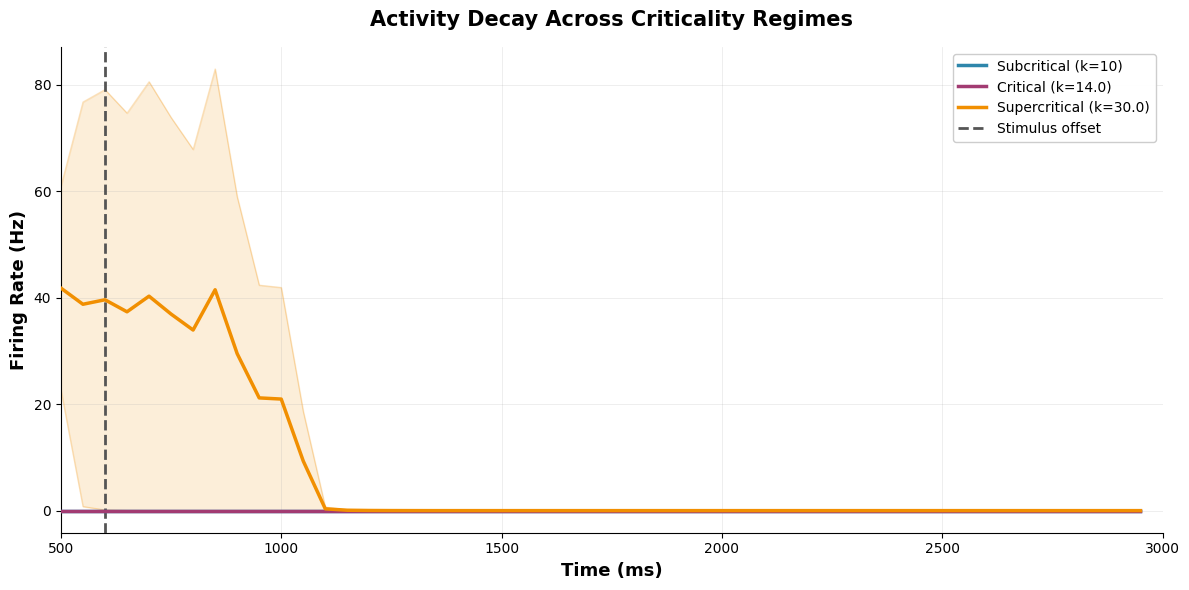

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
from brian2 import start_scope
from src.two_populations.model import IzhikevichNetwork
from src.two_populations.metrics import analyze_simulation_results

ratios = [1.0, 2.0, 3.0, 4.0, 5.0]

# Setup con estilo mejorado
# plt.style.use('seaborn-v0_8-darkgrid')
fig, ax = plt.subplots(figsize=(12, 6))
fr_all = defaultdict(list)

start_range = np.arange(500, 3000, 50)
duration = 250
central_k = np.arange(3, 68, 2.0)

# for ratio in ratios:
#     for k in central_k:
        
# Colores más distinguibles
# k_values = [central_k-2.0, central_k, central_k+2.0] #18, 19.6, 22

k_values = [10, 14.0, 30.0] #18, 19.6, 22
colors = ['#2E86AB', '#A23B72', '#F18F01']  # azul, rojo, verde
labels = ['Subcritical', 'Critical', 'Supercritical']

for (k_value, color, label) in zip(k_values, colors, labels):
    for trial in range(2):
        SIM_CONFIG = {
            'dt_ms': 0.1,
            'T_ms': 3500,
            'warmup_ms': 500
        }

        NETWORK_PARAMS = {
            'pop_A': {
                'Ne': 800, 'Ni': 200,
                'k_exc': k_value, 'k_inh': k_value*3.0,
                'noise_exc': 0.884131778925051, 
                'noise_inh': 0.6041873715553614,
                'p_intra': 0.1, 
                'delay': 0.0,
                'rate_hz': 10.106089400313447,
                'stim_start_ms': 500.0, 
                'stim_duration_ms': 100,
                'stim_base': 0.0, 
                'stim_elevated': 3.0
            }
        }

        start_scope()
        network = IzhikevichNetwork(
            dt_val=SIM_CONFIG['dt_ms'],
            T_total=SIM_CONFIG['T_ms'],
            fixed_seed=100,
            variable_seed=200,
            trial=trial
        )

        pop_A = network.create_population2(name='A', **NETWORK_PARAMS['pop_A'])
        network.setup_monitors(['A'], record_v_dt=0.5, sample_fraction=0.5)
        results = network.run_simulation()

        results_dict = {
            'baseline': analyze_simulation_results(
                spike_mon_A=results['A']['spike_monitor'], 
                spike_mon_B=None,  
                N=1000, 
                condition_name="decay",
                warmup=SIM_CONFIG['warmup_ms'],
                state_monitors={'A': network.monitors['A']},
                delays=None, 
                signal_mode='lfp',
                T_total=SIM_CONFIG['T_ms']
            )
        }
        
        fr_grid = np.zeros(len(start_range))
        for i, start in enumerate(start_range):
            fr_steady = compute_steady_state_fr(results_dict, start_ms=start, duration_ms=duration)
            fr_grid[i] = fr_steady['baseline']['fr_A']
        
        print(f'--- FR : {max(fr_grid)}')
        
        fr_all[k_value].append(fr_grid)
        
        # Trials individuales muy tenues
        
        ax.plot(start_range, fr_grid, '-', color=color, alpha=0.2, linewidth=0.85)
    
    # Media gruesa
    mean_fr = np.mean(fr_all[k_value], axis=0)
    std_fr = np.std(fr_all[k_value], axis=0)
    ax.plot(start_range, mean_fr, '-', color=color, linewidth=2.5, label=f'{label} (k={k_value})', zorder=10) #, 
    ax.fill_between(start_range, mean_fr-std_fr, mean_fr+std_fr, color=color, alpha=0.15)

# Estilo
ax.axvline(600, color='#555555', linestyle='--', linewidth=2, 
        label='Stimulus offset', zorder=5)
ax.set_xlabel('Time (ms)', fontsize=13, fontweight='600')
ax.set_ylabel('Firing Rate (Hz)', fontsize=13, fontweight='600')
ax.set_title('Activity Decay Across Criticality Regimes', 
            fontsize=15, fontweight='700', pad=15)
ax.legend(fontsize=10, framealpha=0.98, loc='upper right', frameon=True)
ax.grid(True, alpha=0.3, linewidth=0.5)
ax.set_xlim(500, 3000)
# ax.set_ylim(0, 65)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.tight_layout()
plt.show()

In [ ]:
# ============= MÉTRICAS CUANTITATIVAS =============
print("\n=== DECAY METRICS ===")
for k_value, label in zip(k_values, labels):
    mean_fr = np.mean(fr_all[k_value], axis=0)
    
    # FR inicial (promedio 600-700ms)
    mask_init = (start_range >= 600) & (start_range < 700)
    fr_init = np.mean(mean_fr[mask_init])
    
    # FR final (promedio 1500-2000ms)
    mask_final = (start_range >= 1500) & (start_range < 2000)
    fr_final = np.mean(mean_fr[mask_final])
    
    # Tiempo al 50% del decay
    fr_50 = fr_init * 0.5
    idx_50 = np.argmin(np.abs(mean_fr - fr_50))
    t_50 = start_range[idx_50] if mean_fr[idx_50] < fr_init else np.nan
    
    print(f"\n{label} (k={k_value}):")
    print(f"  FR initial (600-700ms): {fr_init:.1f} Hz")
    print(f"  FR final (1500-2000ms): {fr_final:.1f} Hz")
    print(f"  Decay: {fr_init - fr_final:.1f} Hz ({100*(fr_init-fr_final)/fr_init:.1f}%)")
    print(f"  t₅₀: {t_50:.0f} ms" if not np.isnan(t_50) else "  t₅₀: >2000 ms")

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter
from brian2 import ms

# =============================================================================
# CÁLCULO DE FR (necesario para heatmap)
# =============================================================================

def compute_steady_state_fr(results_dict, start_ms=1500, duration_ms=1000):
    """Calcula FR promedio en ventana temporal (para heatmap)"""
    fr_stats = {}
    
    for condition, results in results_dict.items():
        ts = results['time_series']
        time = ts['time_fr']
        mask = (time >= start_ms) & (time < start_ms + duration_ms)
        
        fr_A_mean = np.mean(ts['fr_A'][mask]) if np.any(mask) else 0.0
        
        fr_stats[condition] = {
            'fr_A': fr_A_mean,
            'window_start_ms': start_ms,
            'window_duration_ms': duration_ms,
            'n_samples': np.sum(mask)
        }
    
    return fr_stats


def compute_steady_state_fr_by_type(grouped, k_vals, n_trials, 
                                     start_ms=1500, duration_ms=500):
    """Calcula FR_exc, FR_inh, FR_total para cada k"""
    fr_exc_all, fr_inh_all, fr_total_all = [], [], []
    
    for k in k_vals:
        fr_exc_trials, fr_inh_trials, fr_tot_trials = [], [], []
        
        for trial in range(n_trials):
            data = grouped[k][trial]
            
            # Máscara temporal
            t_mask = (data['spike_times']/ms >= start_ms) & \
                     (data['spike_times']/ms < start_ms + duration_ms)
            
            spikes_in_window = data['spike_indices'][t_mask]
            Ne = data['Ne']
            Ni = data['Ni']
            
            # Contar por tipo
            n_exc = np.sum(spikes_in_window < Ne)
            n_inh = np.sum(spikes_in_window >= Ne)
            
            # FR en Hz
            window_s = duration_ms / 1000
            fr_exc_trials.append(n_exc / (Ne * window_s))
            fr_inh_trials.append(n_inh / (Ni * window_s))
            fr_tot_trials.append((n_exc + n_inh) / ((Ne + Ni) * window_s))
        
        fr_exc_all.append((np.mean(fr_exc_trials), np.std(fr_exc_trials)))
        fr_inh_all.append((np.mean(fr_inh_trials), np.std(fr_inh_trials)))
        fr_total_all.append((np.mean(fr_tot_trials), np.std(fr_tot_trials)))
    
    return {
        'exc': np.array(fr_exc_all),
        'inh': np.array(fr_inh_all),
        'total': np.array(fr_total_all)
    }




import multiprocessing as mp
from functools import partial
from src.two_populations.model import IzhikevichNetwork
import numpy as np
from src.two_populations.metrics import analyze_simulation_results, print_network_statistics_table
from src.two_populations.plots.dashboard_plots import plot_connectivity_dashboard, plot_population_dashboard

def run_single_k_trial(args, sim_config, network_params):
    """Worker que retorna time_series para post-procesamiento"""
    k_factor, trial = args
    from brian2 import start_scope
    
    start_scope()
    
    network = IzhikevichNetwork(
        dt_val=sim_config['dt_ms'],
        T_total=sim_config['T_ms'],
        fixed_seed=100,
        variable_seed=200 + trial,
        trial=trial
    )
    
    params = network_params['pop_A'].copy()
    params['k_exc'] = k_factor
    params['k_inh'] = k_factor * 3.9
    
    pop_A = network.create_population2('A', **params)
    network.setup_monitors(['A'], record_v_dt=0.5, sample_fraction=0.5)
    results = network.run_simulation()
    
    full_result = analyze_simulation_results(
        spike_mon_A=results['A']['spike_monitor'],
        spike_mon_B=None,
        N=params['Ne'] + params['Ni'],
        condition_name=f"k={k_factor:.3f}_trial{trial}",
        warmup=sim_config['warmup_ms'],
        state_monitors={'A': network.monitors['A']},
        signal_mode='lfp',
        T_total=sim_config['T_ms']
    )
    
    # Retornar estructura compatible con compute_steady_state_fr
    return {
        'k_factor': k_factor,
        'trial': trial,
        'time_series': full_result['time_series'],
        'spike_times': results['A']['spike_monitor'].t[:],      # ← AÑADIR
        'spike_indices': results['A']['spike_monitor'].i[:],    # ← AÑADIR
        'Ne': params['Ne'],  
        'Ni': params['Ni'],
        'gamma_power': full_result['power_A']['gamma_power'],
    }


noise_int = 5.0 #*0.9 #5.1*0.85
noise_inh_factor = 0.45 #5
intra_delay = 0.0
p_intra = 0.1
Ni = 800
Ne = 200
time = 3000

# Simulation parameters
SIM_CONFIG = {
    'dt_ms': 0.1,
    'T_ms': time,
    'warmup_ms': 500
}

# # Network parameters
NETWORK_PARAMS = {
    'pop_A': {
        'Ne': Ne, 'Ni': Ni,
        'noise_exc': 0.88, 
        'noise_inh': 0.6,
        'p_intra': 0.1, 
        'delay': 0.0,
        'rate_hz':10.1,
        'stim_base':0.0, 'stim_elevated':3.0,
        'stim_start_ms':500.0, 'stim_duration_ms':100.0
    }
}

# # Network parameters
# NETWORK_PARAMS = {
#     'pop_A': {
#         'Ne': Ne, 'Ni': Ni,
#         'noise_exc': noise_int, 'noise_inh': noise_int*noise_inh_factor,
#         'p_intra': p_intra, 'delay': intra_delay,
#         'noise_type': 'gaussian',
#         'step': True,
#         'stim_start_ms': 500.0, 'stim_duration_ms': 500,
#         'stim_base': 0.2, 
#         'stim_elevated': 3.0
#     }
# }

# # Configuración
# Barrido ultra-fino en transiciones
k_pre = np.arange(5, 10, 2.0)           # 3 valores (vs 5)
k_trans1 = np.arange(10, 17, 1.0)       # 70 valores (mantener)
k_inter = np.arange(17, 30, 1.0)        # 26 valores (mantener)
k_trans2 = np.arange(30, 45, 1.0)       # 30 valores (era 75)
k_plateau = np.arange(45, 66, 2.0)      # 21 valores (mantener)

k_factor_values = np.sort(np.concatenate([
    k_pre, k_trans1, k_inter, k_trans2, k_plateau
]))

n_trials = 2
start_range = np.arange(500, 2500, 20)
duration = 200
start = 1600
# Ventanas temporales
time_windows = [(start, duration) for start in start_range if start + duration <= time]

k_trial_pairs = [(k, trial) for k in k_factor_values for trial in range(n_trials)]
n_processes = min(mp.cpu_count() - 1, len(k_trial_pairs))

logger.info(f"Starting sweep: {len(k_factor_values)} k-values × {n_trials} trials")

worker_func = partial(run_single_k_trial, 
                     sim_config=SIM_CONFIG, 
                     network_params=NETWORK_PARAMS)

with mp.Pool(processes=n_processes) as pool:
    results_list = pool.map(worker_func, k_trial_pairs)

# Agrupar por k_factor
from collections import defaultdict
grouped = defaultdict(dict)  # ← dict, no list
for r in results_list:
    grouped[r['k_factor']][r['trial']] = r


INFO       Starting sweep: 49 k-values × 2 trials [brian2]
SUCCESS  | src.two_populations.model:__init__:45 - Network initialized with seeds: {'trial': 1, 'fixed_seed_A': 99, 'fixed_seed_B': 101, 'fixed_seed_common': 100, 'variable_common_current': 204, 'variable_A_current': 204, 'variable_B_current': 207}
SUCCESS  | src.two_populations.model:__init__:45 - Network initialized with seeds: {'trial': 0, 'fixed_seed_A': 99, 'fixed_seed_B': 101, 'fixed_seed_common': 100, 'variable_common_current': 200, 'variable_A_current': 200, 'variable_B_current': 203}
SUCCESS  | src.two_populations.model:__init__:45 - Network initialized with seeds: {'trial': 1, 'fixed_seed_A': 99, 'fixed_seed_B': 101, 'fixed_seed_common': 100, 'variable_common_current': 204, 'variable_A_current': 204, 'variable_B_current': 207}
SUCCESS  | src.two_populations.model:__init__:45 - Network initialized with seeds: {'trial': 1, 'fixed_seed_A': 99, 'fixed_seed_B': 101, 'fixed_seed_common': 100, 'variable_common_current': 204,

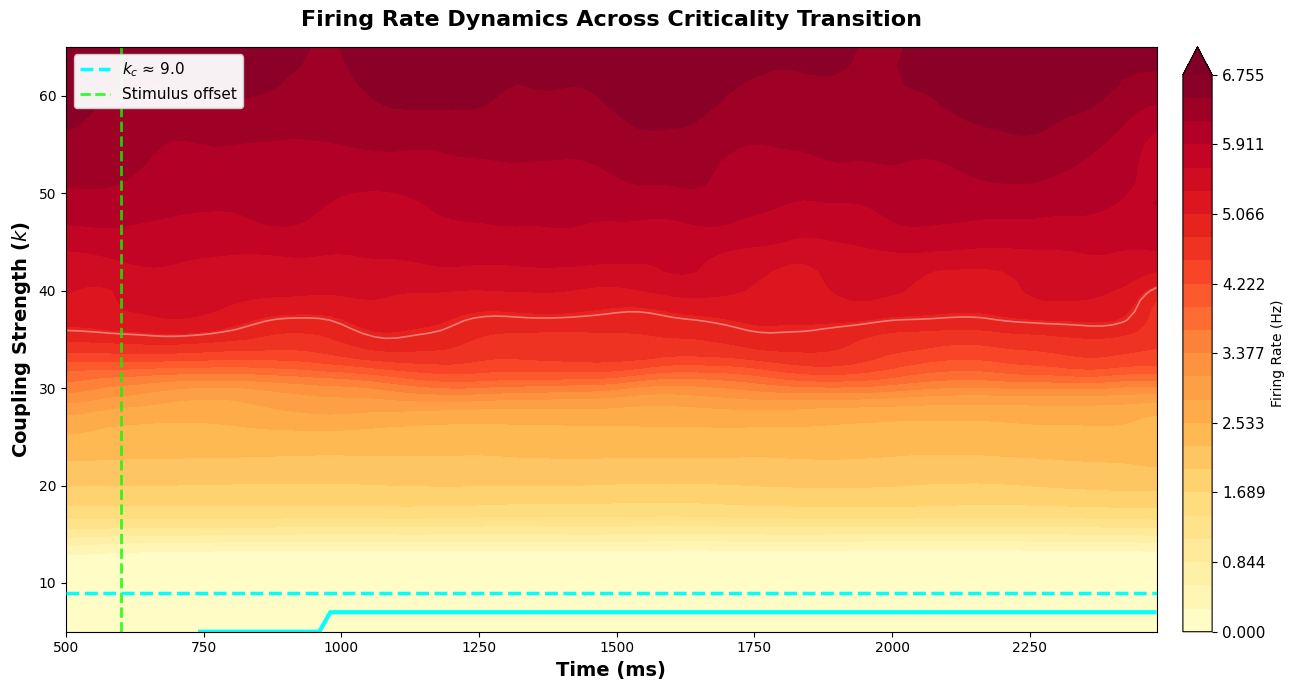

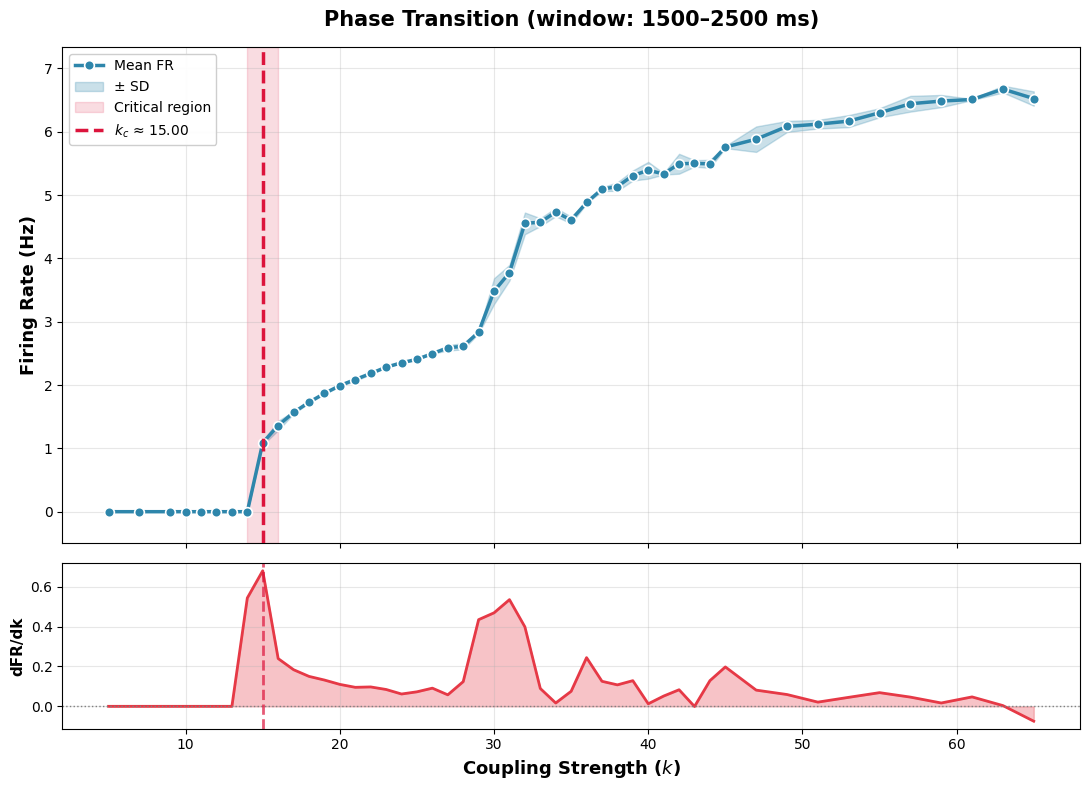


k_c ≈ 15.00 (first k with FR > 0.0 Hz)



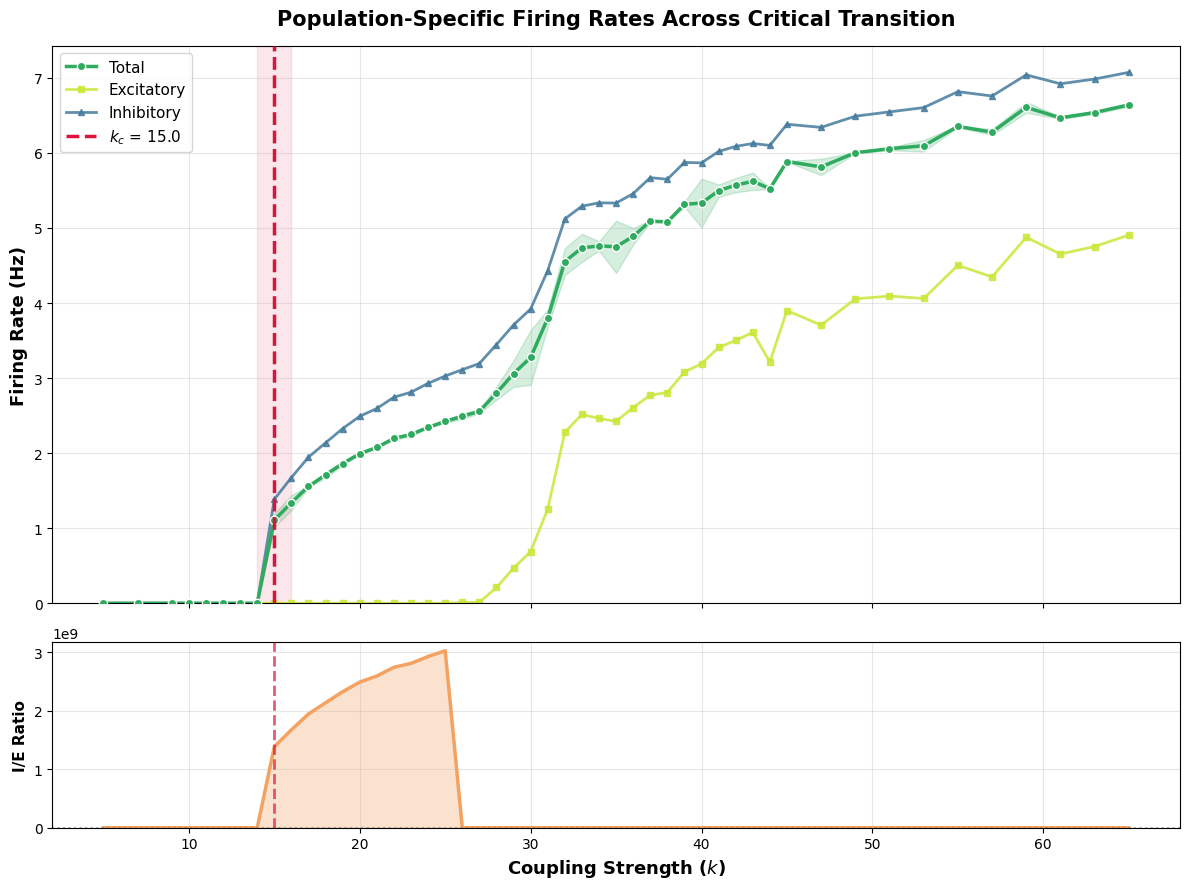

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter

# =============================================================================
# PLOTS
# =============================================================================

def plot_fr_heatmap(grouped, k_sorted, start_range, duration, time, n_trials, 
                    threshold=0.0, stim_offset=600, save_path='fr_dynamics_heatmap.png'):
    
    fr_matrix = np.zeros((len(k_sorted), len(start_range)))
    
    for i, k in enumerate(k_sorted):
        for j, start in enumerate(start_range):
            if start + duration <= time:
                fr_trials = []
                for trial in range(n_trials):
                    results_dict = {'baseline': grouped[k][trial]}
                    fr_steady = compute_steady_state_fr(
                        results_dict, start_ms=start, duration_ms=duration
                    )
                    fr_trials.append(fr_steady['baseline']['fr_A'])
                fr_matrix[i, j] = np.mean(fr_trials)
    
    fr_matrix_smooth = gaussian_filter(fr_matrix, sigma=1.5)
    
    late_mask = start_range >= 1500
    fr_late = fr_matrix_smooth[:, late_mask].mean(axis=1)
    kc_idx = np.where(fr_late > threshold)[0]
    kc_estimate = k_sorted[kc_idx[0]] if len(kc_idx) > 0 else None
    
    fig, ax = plt.subplots(figsize=(14, 7))
    
    levels = np.linspace(0, fr_matrix_smooth.max(), 25)
    im = ax.contourf(start_range, k_sorted, fr_matrix_smooth,
                     levels=levels, cmap='YlOrRd', extend='max')
    
    ax.contour(start_range, k_sorted, fr_matrix_smooth,
               levels=[5, 15, 25, 35], colors='white', alpha=0.4, linewidths=1.2)
    ax.contour(start_range, k_sorted, fr_matrix_smooth, 
               levels=[threshold], colors='cyan', linewidths=3, 
               linestyles='solid')
    
    if kc_estimate:
        ax.axhline(kc_estimate, color='cyan', linestyle='--', linewidth=2.5,
                   label=f'$k_c$ ≈ {kc_estimate:.1f}', zorder=10)
    
    ax.axvline(stim_offset, color='lime', linestyle='--', linewidth=2,
               alpha=0.8, label='Stimulus offset')
    
    ax.set_xlabel('Time (ms)', fontsize=14, fontweight='600')
    ax.set_ylabel('Coupling Strength ($k$)', fontsize=14, fontweight='600')
    ax.set_title('Firing Rate Dynamics Across Criticality Transition',
                 fontsize=16, fontweight='700', pad=15)
    
    cbar = plt.colorbar(im, ax=ax, label='Firing Rate (Hz)', pad=0.02)
    cbar.ax.tick_params(labelsize=11)
    ax.legend(loc='upper left', fontsize=11, framealpha=0.95)
    
    plt.tight_layout()
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()
    
    return fr_matrix_smooth, kc_estimate


def plot_fr_vs_k(grouped, n_trials, start=1500, duration=500, 
                 threshold=0.0, save_path='fr_vs_k_transition.png'):
    
    k_vals = []
    fr_means = []
    fr_stds = []

    for k in sorted(grouped.keys()):
        fr_trials = []
        for trial in range(n_trials):
            results_dict = {'baseline': grouped[k][trial]}
            fr_steady = compute_steady_state_fr(results_dict, start_ms=start, 
                                                duration_ms=duration)
            fr_trials.append(fr_steady['baseline']['fr_A'])
        
        k_vals.append(k)
        fr_means.append(np.mean(fr_trials))
        fr_stds.append(np.std(fr_trials))
    
    k_vals = np.array(k_vals)
    fr_means = np.array(fr_means)
    fr_stds = np.array(fr_stds)
    
    kc_idx = np.where(fr_means > threshold)[0]
    kc = k_vals[kc_idx[0]] if len(kc_idx) > 0 else None
    
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(11, 8), height_ratios=[3, 1], sharex=True)
    
    ax1.plot(k_vals, fr_means, 'o-', linewidth=2.5, markersize=7, 
             color='#2E86AB', markeredgecolor='white', markeredgewidth=1.2,
             label='Mean FR', zorder=5)
    ax1.fill_between(k_vals, fr_means - fr_stds, fr_means + fr_stds,
                     alpha=0.25, color='#2E86AB', label='± SD')
    
    if kc is not None:
        ax1.axvspan(kc - 1, kc + 1, alpha=0.15, color='crimson', label='Critical region')
        ax1.axvline(kc, color='crimson', linestyle='--', linewidth=2.5,
                   label=f'$k_c$ ≈ {kc:.2f}', zorder=10)
    
    ax1.set_ylabel('Firing Rate (Hz)', fontsize=13, fontweight='600')
    ax1.set_title(f'Phase Transition (window: {start}–{start+duration} ms)',
                 fontsize=15, fontweight='700', pad=15)
    ax1.legend(loc='upper left', fontsize=10, framealpha=0.95)
    ax1.grid(alpha=0.3)
    ax1.set_ylim(-0.5, fr_means.max()*1.1)
    
    fr_gradient = np.gradient(fr_means, k_vals)
    ax2.plot(k_vals, fr_gradient, '-', linewidth=2, color='#E63946')
    ax2.axhline(0, color='gray', linestyle=':', linewidth=1)
    ax2.fill_between(k_vals, 0, fr_gradient, alpha=0.3, color='#E63946')
    
    if kc is not None:
        ax2.axvline(kc, color='crimson', linestyle='--', linewidth=2, alpha=0.7)
    
    ax2.set_xlabel('Coupling Strength ($k$)', fontsize=13, fontweight='600')
    ax2.set_ylabel('dFR/dk', fontsize=11, fontweight='600')
    ax2.grid(alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()
    
    print(f"\nk_c ≈ {kc:.2f} (first k with FR > {threshold} Hz)\n")
    
    return k_vals, fr_means, fr_stds, kc


def plot_fr_by_type(k_vals, fr_data, kc, save_path='fr_exc_inh_comparison.png'):
    fig, axes = plt.subplots(2, 1, figsize=(12, 9), 
                             height_ratios=[3, 1], sharex=True)
    
    ax1 = axes[0]
    
    # Total
    ax1.plot(k_vals, fr_data['total'][:, 0], 'o-', 
             color="#2EAB5E", linewidth=2.5, markersize=6,
             markeredgecolor='white', markeredgewidth=1,
             label='Total', zorder=3)
    ax1.fill_between(k_vals, 
                     fr_data['total'][:, 0] - fr_data['total'][:, 1],
                     fr_data['total'][:, 0] + fr_data['total'][:, 1],
                     alpha=0.2, color='#2EAB5E')
    
    # Excitatorio
    ax1.plot(k_vals, fr_data['exc'][:, 0], 's-', markersize=5,
             color="#CCE639", linewidth=2, label='Excitatory', alpha=0.85)
    
    # Inhibitorio
    ax1.plot(k_vals, fr_data['inh'][:, 0], '^-', markersize=5,
             color='#457B9D', linewidth=2, label='Inhibitory', alpha=0.85)
    
    if kc is not None:
        ax1.axvline(kc, color='crimson', linestyle='--', linewidth=2.5, 
                    label=f'$k_c$ = {kc:.1f}', zorder=10)
        ax1.axvspan(kc-1, kc+1, alpha=0.1, color='crimson')
    
    ax1.set_ylabel('Firing Rate (Hz)', fontsize=13, fontweight='600')
    ax1.set_title('Population-Specific Firing Rates Across Critical Transition',
                  fontsize=15, fontweight='700', pad=15)
    
    # ax1.set_yscale('log')
    ax1.legend(loc='upper left', fontsize=11)
    ax1.grid(alpha=0.3)
    ax1.set_ylim(0, None)
    
    # E/I ratio
    ax2 = axes[1]
    ratio = fr_data['inh'][:, 0] / (fr_data['exc'][:, 0] + 1e-9)
    
    ax2.plot(k_vals, ratio, '-', color='#F4A261', linewidth=2.5)
    ax2.fill_between(k_vals, 0, ratio, alpha=0.3, color='#F4A261')
    ax2.axhline(1, color='gray', linestyle=':', linewidth=1.5, alpha=0.6)
    if kc is not None:
        ax2.axvline(kc, color='crimson', linestyle='--', linewidth=2, alpha=0.7)
    
    ax2.set_xlabel('Coupling Strength ($k$)', fontsize=13, fontweight='600')
    ax2.set_ylabel('I/E Ratio', fontsize=11, fontweight='600')
    ax2.grid(alpha=0.3)
    ax2.set_ylim(0, None)
    
    
    
    plt.tight_layout()
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()


# =============================================================================
# EJECUCIÓN
# =============================================================================

k_sorted = sorted(grouped.keys())

# Heatmap
fr_matrix, kc_heatmap = plot_fr_heatmap(
    grouped, k_sorted, start_range, duration, time, n_trials, threshold=0.0
)

# FR total
k_vals, fr_means, fr_stds, kc = plot_fr_vs_k(
    grouped, n_trials, start=1500, duration=1000, threshold=0.0
)

# FR por tipo (CALCULAR DATOS PRIMERO)
fr_data = compute_steady_state_fr_by_type(
    grouped, k_vals, n_trials, start_ms=1500, duration_ms=1000
)

plot_fr_by_type(k_vals, fr_data, kc, save_path='fr_exc_inh_comparison.png')

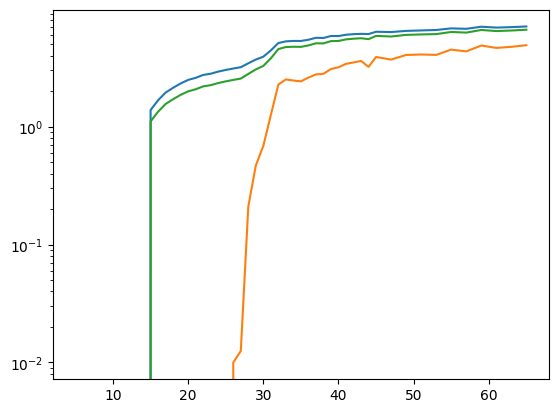

In [19]:
plt.plot(k_vals, fr_data['inh'][:, 0])
plt.plot(k_vals, fr_data['exc'][:, 0])
plt.plot(k_vals, fr_data['total'][:, 0])

plt.yscale('log')
plt.show()


In [18]:
fr_data

{'exc': array([[0.    , 0.    ],
        [0.    , 0.    ],
        [0.    , 0.    ],
        [0.    , 0.    ],
        [0.    , 0.    ],
        [0.    , 0.    ],
        [0.    , 0.    ],
        [0.    , 0.    ],
        [0.    , 0.    ],
        [0.    , 0.    ],
        [0.    , 0.    ],
        [0.    , 0.    ],
        [0.    , 0.    ],
        [0.    , 0.    ],
        [0.    , 0.    ],
        [0.    , 0.    ],
        [0.    , 0.    ],
        [0.    , 0.    ],
        [0.    , 0.    ],
        [0.01  , 0.01  ],
        [0.0125, 0.0125],
        [0.21  , 0.07  ],
        [0.4675, 0.1675],
        [0.6875, 0.4375],
        [1.255 , 0.185 ],
        [2.2775, 0.2275],
        [2.515 , 0.225 ],
        [2.4625, 0.1075],
        [2.4225, 0.5825],
        [2.6075, 0.1175],
        [2.7725, 0.0725],
        [2.8075, 0.0125],
        [3.0825, 0.0775],
        [3.19  , 0.53  ],
        [3.4075, 0.1725],
        [3.5025, 0.1675],
        [3.6075, 0.1575],
        [3.215 , 0.025 ],
     

In [ ]:
# ==========================================================
# Barrido para curvas F(r) estilo Kinouchi (versión corregida)
# ==========================================================
import numpy as np
import matplotlib.pyplot as plt

# --- Parámetros del barrido ---
k_factor_values = np.arange(2, 60.0, 2)  # Varios k cerca de Kc
noise_int_values = np.logspace(np.log10(0.5), np.log10(15), 12)  # ~0.316 a ~6.3 (escala log)

# Estructura para guardar resultados
all_curves = {
    k: {'r': noise_int_values.tolist(), 'F_trials': [[] for _ in noise_int_values]}
    for k in k_factor_values
}

# --- Parámetros de red ---
p_intra = 0.1
Ni, Ne = 200, 800

SIM_CONFIG = {'dt_ms': 0.1, 'T_ms': 2000, 'warmup_ms': 500}

# --- Barrido principal ---
for trial in range(2):
    for k_factor in k_factor_values:
        for i, noise_int in enumerate(noise_int_values):
            logger.info(f"k={k_factor:.1f}, r={noise_int:.3f}")
            
            start_scope()
            network = IzhikevichNetwork(
                dt_val=SIM_CONFIG['dt_ms'],
                T_total=SIM_CONFIG['T_ms'],
                fixed_seed=100,
                variable_seed=200 + trial * 10 + i,  # cambia semilla por trial
                trial=trial
            )
            
            params = {
                'Ne': Ne, 'Ni': Ni,
                'k_exc': k_factor,
                'k_inh': k_factor*3.9,
                'noise_exc': 0.88,
                'noise_inh': 0.6,
                'p_intra': p_intra,
                'delay': 0.0,
                'rate_hz': noise_int,
                'stim_base':1.0, 'stim_elevated': None,
                'stim_start_ms': None, 'stim_duration_ms': None
            }
            
            network.create_population2('A', **params)
            network.setup_monitors(['A'], record_v_dt=0.5, sample_fraction=0.5)
            results = network.run_simulation()
            
            # --- Análisis ---
            analysis = analyze_simulation_results(
                spike_mon_A=results['A']['spike_monitor'],
                spike_mon_B=None,
                N=Ne + Ni,
                warmup=SIM_CONFIG['warmup_ms'],
                state_monitors={'A': network.monitors['A']},
                signal_mode='lfp',
                T_total=SIM_CONFIG['T_ms']
            )
            
            # FR promedio (post-warmup)
            fr_mean = np.mean(analysis['time_series']['fr_A'])
            all_curves[k_factor]['F_trials'][i].append(fr_mean)

# ==========================================================
# Postprocesado: calcular medias y desviaciones
# ==========================================================
for k in k_factor_values:
    F_mean = [np.mean(F_trials) if len(F_trials) > 0 else np.nan
            for F_trials in all_curves[k]['F_trials']]
    F_std = [np.std(F_trials) if len(F_trials) > 0 else np.nan
            for F_trials in all_curves[k]['F_trials']]
    
    all_curves[k]['F'] = F_mean
    all_curves[k]['F_std'] = F_std

# ==========================================================
# Plot de las curvas F(r)
# ==========================================================
fig, ax = plt.subplots(figsize=(10, 7))

for k in k_factor_values:
    ax.errorbar(
        all_curves[k]['r'],
        all_curves[k]['F'],
        yerr=all_curves[k]['F_std'],
        fmt='o-',
        capsize=4,
        label=f'k={k:.1f}'
    )

ax.set_xscale('log')
ax.set_xlabel('Intensidad del ruido r (Hz)', fontsize=12)
ax.set_ylabel('Respuesta promedio F (Hz)', fontsize=12)
ax.legend(title='Factor k')
ax.grid(True, which='both', ls='--', alpha=0.5)
ax.set_title('Curvas F(r) estilo Kinouchi', fontsize=14)
plt.tight_layout()
plt.show()


In [ ]:
def compute_dynamic_range_db(r_values, F_values):
    F0, Fmax = F_values.min(), F_values.max()
    F01 = F0 + 0.1*(Fmax - F0)
    F09 = F0 + 0.9*(Fmax - F0)
    
    idx_01 = np.argmin(np.abs(F_values - F01))
    idx_09 = np.argmin(np.abs(F_values - F09))
    
    r01, r09 = r_values[idx_01], r_values[idx_09]
    return 10*np.log10(r09/r01) if r01 > 0 else 0

# Aplicar a cada curva
for k in all_curves.keys():
    dr = compute_dynamic_range_db(np.array(all_curves[k]['r']), 
                                   np.array(all_curves[k]['F']))
    print(f"k={k}: ∆={dr:.1f} dB")

INFO       E/I ratio = 1.00 [brian2]


SUCCESS  | src.two_populations.model:__init__:45 - Network initialized with seeds: {'trial': 0, 'fixed_seed_A': 99, 'fixed_seed_B': 101, 'fixed_seed_common': 100, 'variable_common_current': 200, 'variable_A_current': 200, 'variable_B_current': 203}
SUCCESS  | src.two_populations.model:__init__:45 - Network initialized with seeds: {'trial': 2, 'fixed_seed_A': 99, 'fixed_seed_B': 101, 'fixed_seed_common': 100, 'variable_common_current': 208, 'variable_A_current': 208, 'variable_B_current': 211}
SUCCESS  | src.two_populations.model:__init__:45 - Network initialized with seeds: {'trial': 2, 'fixed_seed_A': 99, 'fixed_seed_B': 101, 'fixed_seed_common': 100, 'variable_common_current': 208, 'variable_A_current': 208, 'variable_B_current': 211}
SUCCESS  | src.two_populations.model:__init__:45 - Network initialized with seeds: {'trial': 4, 'fixed_seed_A': 99, 'fixed_seed_B': 101, 'fixed_seed_common': 100, 'variable_common_current': 216, 'variable_A_current': 216, 'variable_B_current': 219}
SUCC

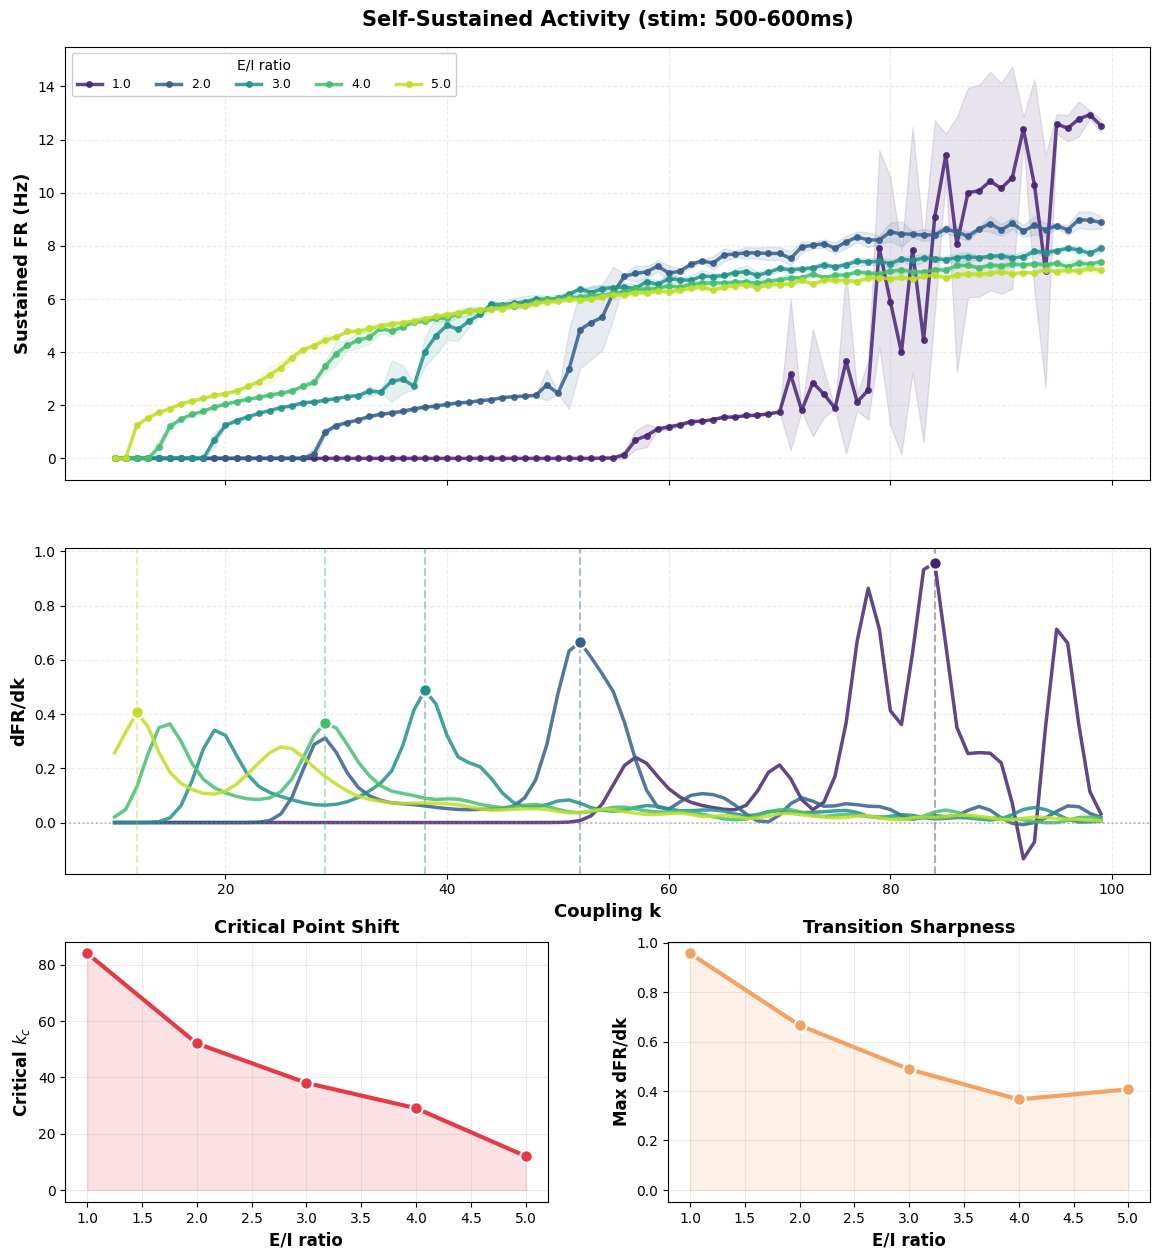

   ratio   k_c  sensitivity  variance
0    1.0  84.0     0.956500  4.800225
1    2.0  52.0     0.665517  1.491120
2    3.0  38.0     0.487598  0.782679
3    4.0  29.0     0.366046  0.451327
4    5.0  12.0     0.406503  0.305335


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict
from scipy.ndimage import gaussian_filter1d
import multiprocessing as mp
from functools import partial
from src.two_populations.model import IzhikevichNetwork
import numpy as np
from src.two_populations.model import IzhikevichNetwork
from src.two_populations.metrics import analyze_simulation_results, print_network_statistics_table
from src.two_populations.plots.dashboard_plots import plot_connectivity_dashboard, plot_population_dashboard
from brian2 import *

# =============================================================================
# CÁLCULO DE FR (necesario para heatmap)
# =============================================================================

def compute_steady_state_fr(results_dict, start_ms=1500, duration_ms=1000):
    """Calcula FR promedio en ventana temporal (para heatmap)"""
    fr_stats = {}
    
    for condition, results in results_dict.items():
        ts = results['time_series']
        time = ts['time_fr']
        mask = (time >= start_ms) & (time < start_ms + duration_ms)
        
        fr_A_mean = np.mean(ts['fr_A'][mask]) if np.any(mask) else 0.0
        
        fr_stats[condition] = {
            'fr_A': fr_A_mean,
            'window_start_ms': start_ms,
            'window_duration_ms': duration_ms,
            'n_samples': np.sum(mask)
        }
    
    return fr_stats


def compute_steady_state_fr_by_type(grouped, k_vals, n_trials, 
                                     start_ms=1500, duration_ms=500):
    """Calcula FR_exc, FR_inh, FR_total para cada k"""
    fr_exc_all, fr_inh_all, fr_total_all = [], [], []
    
    for k in k_vals:
        fr_exc_trials, fr_inh_trials, fr_tot_trials = [], [], []
        
        for trial in range(n_trials):
            data = grouped[k][trial]
            
            # Máscara temporal
            t_mask = (data['spike_times']/ms >= start_ms) & \
                     (data['spike_times']/ms < start_ms + duration_ms)
            
            spikes_in_window = data['spike_indices'][t_mask]
            Ne = data['Ne']
            Ni = data['Ni']
            
            # Contar por tipo
            n_exc = np.sum(spikes_in_window < Ne)
            n_inh = np.sum(spikes_in_window >= Ne)
            
            # FR en Hz
            window_s = duration_ms / 1000
            fr_exc_trials.append(n_exc / (Ne * window_s))
            fr_inh_trials.append(n_inh / (Ni * window_s))
            fr_tot_trials.append((n_exc + n_inh) / ((Ne + Ni) * window_s))
        
        fr_exc_all.append((np.mean(fr_exc_trials), np.std(fr_exc_trials)))
        fr_inh_all.append((np.mean(fr_inh_trials), np.std(fr_inh_trials)))
        fr_total_all.append((np.mean(fr_tot_trials), np.std(fr_tot_trials)))
    
    return {
        'exc': np.array(fr_exc_all),
        'inh': np.array(fr_inh_all),
        'total': np.array(fr_total_all)
    }
    
def run_single_k_trial(args, sim_config, network_params):
    """Worker que retorna time_series para post-procesamiento"""
    k_factor, trial = args
    from brian2 import start_scope
    
    start_scope()
    
    network = IzhikevichNetwork(
        dt_val=sim_config['dt_ms'],
        T_total=sim_config['T_ms'],
        fixed_seed=100,
        variable_seed=200 + trial,
        trial=trial
    )
    
    params = network_params['pop_A'].copy()
    # params['k_exc'] = k_factor
    # params['k_inh'] = k_factor * rtio
    
    pop_A = network.create_population2('A', **params)
    network.setup_monitors(['A'], record_v_dt=0.5, sample_fraction=0.5)
    results = network.run_simulation()
    
    full_result = analyze_simulation_results(
        spike_mon_A=results['A']['spike_monitor'],
        spike_mon_B=None,
        N=params['Ne'] + params['Ni'],
        condition_name=f"k={k_factor:.3f}_trial{trial}",
        warmup=sim_config['warmup_ms'],
        state_monitors={'A': network.monitors['A']},
        signal_mode='lfp',
        T_total=sim_config['T_ms']
    )
    
    # Retornar estructura compatible con compute_steady_state_fr
    return {
        'k_factor': k_factor,
        'trial': trial,
        'time_series': full_result['time_series'],
        'spike_times': results['A']['spike_monitor'].t[:],      # ← AÑADIR
        'spike_indices': results['A']['spike_monitor'].i[:],    # ← AÑADIR
        'Ne': params['Ne'],  
        'Ni': params['Ni'],
        'gamma_power': full_result['power_A']['gamma_power'],
    }

# =============================================================================
# CONFIGURACIÓN
# =============================================================================

EI_RATIOS = [1.0, 2.0, 3.0, 4.0, 5.0]
N_TRIALS = 5
K_VALUES = np.arange(10, 100, 1.0)

Ni, Ne = 800, 200


SIM_CONFIG = {'dt_ms': 0.1, 'T_ms': 3000, 'warmup_ms': 500}

NETWORK_PARAMS = {
    'pop_A': {
        'Ne': Ne, 'Ni': Ni,
        'noise_exc': 0.88, 
        'noise_inh': 0.60,
        'p_intra': 0.1, 
        'delay': 0.0,
        'rate_hz': 10.0,
        'stim_start_ms': 500.0, 
        'stim_duration_ms': 100.0,
        'stim_base': 0.0, 
        'stim_elevated': 3.0
    }
}

# =============================================================================
# EJECUCIÓN
# =============================================================================

results_global = {}

for ratio in EI_RATIOS:
    logger.info(f"E/I ratio = {ratio:.2f}")
    
    def run_ratio_trial(args):
        k_factor, trial = args
        network_params_ratio = {'pop_A': NETWORK_PARAMS['pop_A'].copy()}
        network_params_ratio['pop_A']['k_inh'] = k_factor * ratio
        network_params_ratio['pop_A']['k_exc'] = k_factor
        
        return run_single_k_trial((k_factor, trial),
                                  sim_config=SIM_CONFIG,
                                  network_params=network_params_ratio)
    
    k_trial_pairs = [(k, t) for k in K_VALUES for t in range(N_TRIALS)]
    
    with mp.Pool(processes=mp.cpu_count()-1) as pool:
        results_list = pool.map(run_ratio_trial, k_trial_pairs)
    
    grouped = defaultdict(dict)
    for r in results_list:
        grouped[r['k_factor']][r['trial']] = r
    results_global[ratio] = grouped

# =============================================================================
# ANÁLISIS
# =============================================================================

critical_data = []
fig = plt.figure(figsize=(14, 15))
gs = fig.add_gridspec(3, 2, height_ratios=[2, 1.5, 1.2], hspace=0.2, wspace=0.25)

ax_fr = fig.add_subplot(gs[0, :])
ax_grad = fig.add_subplot(gs[1, :], sharex=ax_fr)
ax_kc = fig.add_subplot(gs[2, 0])
ax_sens = fig.add_subplot(gs[2, 1])

colors = plt.cm.viridis(np.linspace(0.1, 0.9, len(EI_RATIOS)))

for idx, ratio in enumerate(EI_RATIOS):
    grouped = results_global[ratio]
    k_vals = sorted(grouped.keys())
    
    fr_means, fr_stds = [], []
    for k in k_vals:
        fr_trials = []
        for trial in range(N_TRIALS):
            results_dict = {'baseline': grouped[k][trial]}
            # Medir post-estímulo: [600, 2800] ms
            fr_steady = compute_steady_state_fr(results_dict, 
                                                start_ms=1500, 
                                                duration_ms=2500)
            fr_trials.append(fr_steady['baseline']['fr_A'])
        
        fr_means.append(np.mean(fr_trials))
        fr_stds.append(np.std(fr_trials))
    
    fr_smooth = gaussian_filter1d(fr_means, sigma=1.5)
    grad = np.gradient(fr_smooth, k_vals)
    
    kc_idx = np.argmax(grad)
    k_c = k_vals[kc_idx]
    
    critical_data.append({
        'ratio': ratio, 'k_c': k_c,
        'sensitivity': grad[kc_idx],
        'variance': np.max(fr_stds)
    })
    
    ax_fr.plot(k_vals, fr_means, 'o-', color=colors[idx], 
               label=f'{ratio:.1f}', linewidth=2.5, markersize=4, alpha=0.85)
    ax_fr.fill_between(k_vals, np.array(fr_means) - np.array(fr_stds),
                       np.array(fr_means) + np.array(fr_stds),
                       alpha=0.12, color=colors[idx])
    
    ax_grad.plot(k_vals, grad, '-', color=colors[idx], linewidth=2.5, alpha=0.85)
    ax_grad.axvline(k_c, color=colors[idx], linestyle='--', linewidth=1.5, alpha=0.4)
    ax_grad.scatter([k_c], [grad[kc_idx]], s=80, color=colors[idx], 
                    edgecolor='white', linewidth=1.5, zorder=5)

# Styling
ax_fr.set_ylabel('Sustained FR (Hz)', fontsize=13, fontweight='600')
ax_fr.legend(title='E/I ratio', ncol=5, fontsize=9, framealpha=0.95)
ax_fr.grid(alpha=0.25, linestyle='--')
ax_fr.set_title('Self-Sustained Activity (stim: 1500-2500)', 
                fontsize=15, fontweight='700', pad=15)
ax_fr.tick_params(labelbottom=False)

ax_grad.axhline(0, color='gray', linestyle=':', linewidth=1.2, alpha=0.6)
ax_grad.set_xlabel('Coupling k', fontsize=13, fontweight='600')
ax_grad.set_ylabel('dFR/dk', fontsize=13, fontweight='600')
ax_grad.grid(alpha=0.25, linestyle='--')

crit_df = pd.DataFrame(critical_data)

ax_kc.plot(crit_df['ratio'], crit_df['k_c'], 'o-', 
           color='#E63946', linewidth=3, markersize=9, 
           markeredgecolor='white', markeredgewidth=1.5)
ax_kc.fill_between(crit_df['ratio'], crit_df['k_c'], alpha=0.15, color='#E63946')
ax_kc.set_xlabel('E/I ratio', fontsize=12, fontweight='600')
ax_kc.set_ylabel('Critical $k_c$', fontsize=12, fontweight='600')
ax_kc.set_title('Critical Point Shift', fontsize=13, fontweight='700')
ax_kc.grid(alpha=0.25)

ax_sens.plot(crit_df['ratio'], crit_df['sensitivity'], 'o-',
             color='#F4A261', linewidth=3, markersize=9,
             markeredgecolor='white', markeredgewidth=1.5)
ax_sens.fill_between(crit_df['ratio'], crit_df['sensitivity'], 
                     alpha=0.15, color='#F4A261')
ax_sens.set_xlabel('E/I ratio', fontsize=12, fontweight='600')
ax_sens.set_ylabel('Max dFR/dk', fontsize=12, fontweight='600')
ax_sens.set_title('Transition Sharpness', fontsize=13, fontweight='700')
ax_sens.grid(alpha=0.25)
plt.tight_layout()

plt.savefig('ei_ratio_sustained.png', dpi=300, bbox_inches='tight')
plt.show()

print(crit_df)

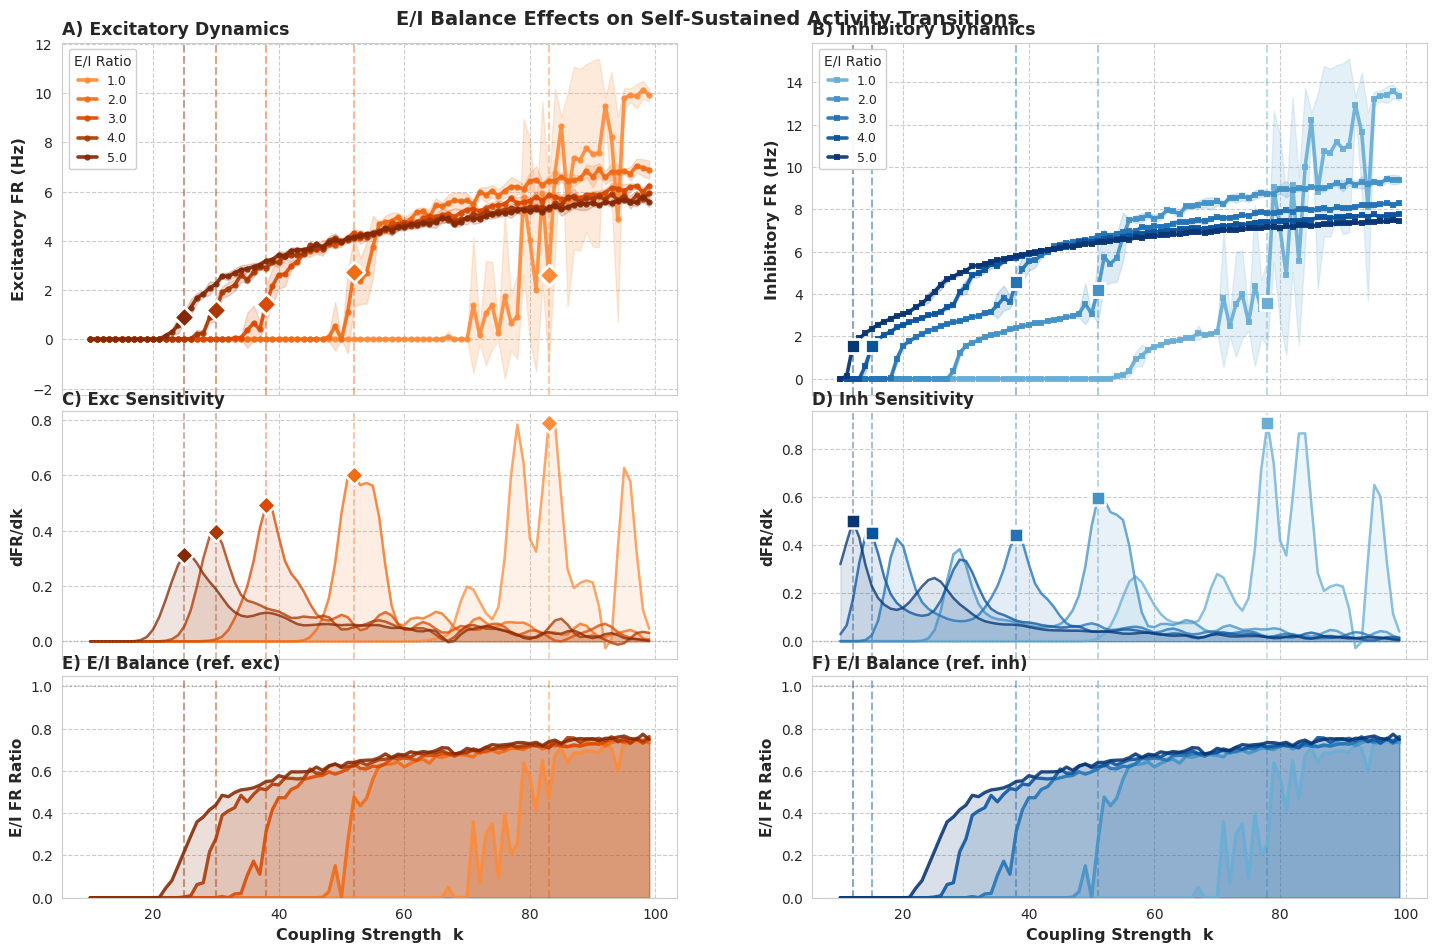


CRITICAL POINTS SUMMARY
 ratio  k_c_exc  k_c_inh  sens_exc  sens_inh
  1.00    83.00    78.00      0.79      0.91
  2.00    52.00    51.00      0.60      0.60
  3.00    38.00    38.00      0.49      0.44
  4.00    30.00    15.00      0.40      0.45
  5.00    25.00    12.00      0.31      0.50


In [15]:
# =============================================================================
# VISUALIZACIÓN: 2 COLUMNAS (EXC | INH)
# =============================================================================

import seaborn as sns
sns.set_style("whitegrid", {'grid.linestyle': '--', 'grid.alpha': 0.3})

critical_data = []

# Layout optimizado: más compacto
fig = plt.figure(figsize=(15, 9.5))
gs = fig.add_gridspec(3, 2, height_ratios=[1.35, 0.95, 0.85], 
                      hspace=0.06, wspace=0.22,
                      top=0.96, bottom=0.06, left=0.07, right=0.98)

ax_exc = fig.add_subplot(gs[0, 0])
ax_inh = fig.add_subplot(gs[0, 1])
ax_grad_exc = fig.add_subplot(gs[1, 0], sharex=ax_exc)
ax_grad_inh = fig.add_subplot(gs[1, 1], sharex=ax_inh)
ax_ratio_exc = fig.add_subplot(gs[2, 0], sharex=ax_exc)
ax_ratio_inh = fig.add_subplot(gs[2, 1], sharex=ax_inh)

# Colores distinguibles
colors_exc = plt.cm.Oranges(np.linspace(0.50, 0.98, len(EI_RATIOS)))
colors_inh = plt.cm.Blues(np.linspace(0.50, 0.98, len(EI_RATIOS)))

for idx, ratio in enumerate(EI_RATIOS):
    grouped = results_global[ratio]
    k_vals = sorted(grouped.keys())
    
    # Calcular FR por tipo
    fr_exc_means, fr_exc_stds = [], []
    fr_inh_means, fr_inh_stds = [], []
    
    for k in k_vals:
        fr_exc_trials, fr_inh_trials = [], []
        
        for trial in range(N_TRIALS):
            results_dict = {'baseline': grouped[k][trial]}
            fr_steady = compute_steady_state_fr_by_type(
                results_dict, start_ms=1500, duration_ms=1500
            )
            fr_exc_trials.append(fr_steady['baseline']['fr_exc'])
            fr_inh_trials.append(fr_steady['baseline']['fr_inh'])
        
        fr_exc_means.append(np.mean(fr_exc_trials))
        fr_exc_stds.append(np.std(fr_exc_trials))
        fr_inh_means.append(np.mean(fr_inh_trials))
        fr_inh_stds.append(np.std(fr_inh_trials))
    
    # Suavizar y calcular gradientes
    fr_exc_smooth = gaussian_filter1d(fr_exc_means, sigma=1.5)
    fr_inh_smooth = gaussian_filter1d(fr_inh_means, sigma=1.5)
    grad_exc = np.gradient(fr_exc_smooth, k_vals)
    grad_inh = np.gradient(fr_inh_smooth, k_vals)
    
    # Ratio E/I instantáneo (evitar división por cero)
    ratio_ei = np.array([e/i if i > 0.1 else 0 for e, i in zip(fr_exc_means, fr_inh_means)])
    
    # Puntos críticos
    kc_exc_idx = np.argmax(grad_exc)
    kc_inh_idx = np.argmax(grad_inh)
    
    critical_data.append({
        'ratio': ratio,
        'k_c_exc': k_vals[kc_exc_idx],
        'k_c_inh': k_vals[kc_inh_idx],
        'sens_exc': grad_exc[kc_exc_idx],
        'sens_inh': grad_inh[kc_inh_idx]
    })
    
    # === PANEL EXCITATORIO ===
    ax_exc.plot(k_vals, fr_exc_means, 'o-', color=colors_exc[idx],
                linewidth=2.6, markersize=4.5, alpha=0.92, 
                label=f'{ratio:.1f}', markeredgewidth=0)
    ax_exc.fill_between(k_vals, 
                        np.array(fr_exc_means) - np.array(fr_exc_stds),
                        np.array(fr_exc_means) + np.array(fr_exc_stds),
                        alpha=0.18, color=colors_exc[idx])
    ax_exc.axvline(k_vals[kc_exc_idx], color=colors_exc[idx], 
                   linestyle='--', linewidth=1.5, alpha=0.45, zorder=1)
    ax_exc.scatter([k_vals[kc_exc_idx]], [fr_exc_means[kc_exc_idx]], 
                   s=110, color=colors_exc[idx], edgecolor='white', 
                   linewidth=2, zorder=10, marker='D')
    
    # === PANEL INHIBITORIO ===
    ax_inh.plot(k_vals, fr_inh_means, 's-', color=colors_inh[idx],
                linewidth=2.6, markersize=4.5, alpha=0.92, 
                label=f'{ratio:.1f}', markeredgewidth=0)
    ax_inh.fill_between(k_vals,
                        np.array(fr_inh_means) - np.array(fr_inh_stds),
                        np.array(fr_inh_means) + np.array(fr_inh_stds),
                        alpha=0.18, color=colors_inh[idx])
    ax_inh.axvline(k_vals[kc_inh_idx], color=colors_inh[idx],
                   linestyle='--', linewidth=1.5, alpha=0.45, zorder=1)
    ax_inh.scatter([k_vals[kc_inh_idx]], [fr_inh_means[kc_inh_idx]],
                   s=110, color=colors_inh[idx], edgecolor='white',
                   linewidth=2, zorder=10, marker='s')
    
    # === GRADIENTES (más sutiles) ===
    ax_grad_exc.plot(k_vals, grad_exc, '-', color=colors_exc[idx], 
                     linewidth=1.8, alpha=0.75)
    ax_grad_exc.fill_between(k_vals, 0, grad_exc, 
                             alpha=0.12, color=colors_exc[idx])
    ax_grad_exc.axvline(k_vals[kc_exc_idx], color=colors_exc[idx], 
                        linestyle='--', linewidth=1.3, alpha=0.4, zorder=1)
    ax_grad_exc.scatter([k_vals[kc_exc_idx]], [grad_exc[kc_exc_idx]], 
                        s=90, color=colors_exc[idx], edgecolor='white', 
                        linewidth=1.8, zorder=10, marker='D')
    
    ax_grad_inh.plot(k_vals, grad_inh, '-', color=colors_inh[idx],
                     linewidth=1.8, alpha=0.75)
    ax_grad_inh.fill_between(k_vals, 0, grad_inh,
                             alpha=0.12, color=colors_inh[idx])
    ax_grad_inh.axvline(k_vals[kc_inh_idx], color=colors_inh[idx],
                        linestyle='--', linewidth=1.3, alpha=0.4, zorder=1)
    ax_grad_inh.scatter([k_vals[kc_inh_idx]], [grad_inh[kc_inh_idx]],
                        s=90, color=colors_inh[idx], edgecolor='white',
                        linewidth=1.8, zorder=10, marker='s')
    
    # === RATIO E/I ===
    ax_ratio_exc.plot(k_vals, ratio_ei, '-', color=colors_exc[idx],
                      linewidth=2.4, alpha=0.88)
    ax_ratio_exc.fill_between(k_vals, ratio_ei, alpha=0.15, color=colors_exc[idx])
    ax_ratio_exc.axvline(k_vals[kc_exc_idx], color=colors_exc[idx],
                         linestyle='--', linewidth=1.5, alpha=0.45, zorder=1)
    
    # Mismo ratio E/I en panel inh (para comparación)
    ax_ratio_inh.plot(k_vals, ratio_ei, '-', color=colors_inh[idx],
                      linewidth=2.4, alpha=0.88)
    ax_ratio_inh.fill_between(k_vals, ratio_ei, alpha=0.15, color=colors_inh[idx])
    ax_ratio_inh.axvline(k_vals[kc_inh_idx], color=colors_inh[idx],
                         linestyle='--', linewidth=1.5, alpha=0.45, zorder=1)

# =============================================================================
# STYLING
# =============================================================================

# Panel Exc: FR
ax_exc.set_ylabel('Excitatory FR (Hz)', fontsize=11.5, fontweight='600')
ax_exc.legend(title='E/I Ratio', ncol=1, fontsize=9, framealpha=0.95, 
              loc='upper left', title_fontsize=10, handlelength=1.5)
ax_exc.set_title('A) Excitatory Dynamics', 
                 fontsize=12.5, fontweight='700', pad=6, loc='left')
ax_exc.tick_params(labelbottom=False, labelsize=10)

# Panel Inh: FR
ax_inh.set_ylabel('Inhibitory FR (Hz)', fontsize=11.5, fontweight='600')
ax_inh.legend(title='E/I Ratio', ncol=1, fontsize=9, framealpha=0.95,
              loc='upper left', title_fontsize=10, handlelength=1.5)
ax_inh.set_title('B) Inhibitory Dynamics', 
                 fontsize=12.5, fontweight='700', pad=6, loc='left')
ax_inh.tick_params(labelbottom=False, labelsize=10)

# Panel Exc: Gradiente
ax_grad_exc.axhline(0, color='gray', linestyle=':', linewidth=1.0, alpha=0.5)
ax_grad_exc.set_ylabel('dFR/dk', fontsize=11, fontweight='600')
ax_grad_exc.set_title('C) Exc Sensitivity', 
                      fontsize=12, fontweight='700', pad=5, loc='left')
ax_grad_exc.tick_params(labelbottom=False, labelsize=10)

# Panel Inh: Gradiente
ax_grad_inh.axhline(0, color='gray', linestyle=':', linewidth=1.0, alpha=0.5)
ax_grad_inh.set_ylabel('dFR/dk', fontsize=11, fontweight='600')
ax_grad_inh.set_title('D) Inh Sensitivity', 
                      fontsize=12, fontweight='700', pad=5, loc='left')
ax_grad_inh.tick_params(labelbottom=False, labelsize=10)

# Panel Exc: Ratio E/I
ax_ratio_exc.axhline(1, color='gray', linestyle=':', linewidth=1.1, alpha=0.6)
ax_ratio_exc.set_xlabel('Coupling Strength  k', fontsize=11.5, fontweight='600')
ax_ratio_exc.set_ylabel('E/I FR Ratio', fontsize=11, fontweight='600')
ax_ratio_exc.set_title('E) E/I Balance (ref. exc)', 
                       fontsize=12, fontweight='700', pad=5, loc='left')
ax_ratio_exc.tick_params(labelsize=10)
ax_ratio_exc.set_ylim([0, None])

# Panel Inh: Ratio E/I
ax_ratio_inh.axhline(1, color='gray', linestyle=':', linewidth=1.1, alpha=0.6)
ax_ratio_inh.set_xlabel('Coupling Strength  k', fontsize=11.5, fontweight='600')
ax_ratio_inh.set_ylabel('E/I FR Ratio', fontsize=11, fontweight='600')
ax_ratio_inh.set_title('F) E/I Balance (ref. inh)', 
                       fontsize=12, fontweight='700', pad=5, loc='left')
ax_ratio_inh.tick_params(labelsize=10)
ax_ratio_inh.set_ylim([0, None])

# Título global más compacto
fig.suptitle('E/I Balance Effects on Self-Sustained Activity Transitions', 
             fontsize=14, fontweight='800', y=0.995)

plt.savefig('./ei_ratio_separated.png', 
            dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

# Tabla resumen
crit_df = pd.DataFrame(critical_data)
print("\n" + "="*60)
print("CRITICAL POINTS SUMMARY")
print("="*60)
print(crit_df.to_string(index=False, float_format='%.2f'))
print("="*60)

In [1]:
# =============================================================================
# VISUALIZACIÓN: 2×2 + PANEL INFERIOR COMPLETO
# =============================================================================

import seaborn as sns
sns.set_style("whitegrid", {'grid.linestyle': '--', 'grid.alpha': 0.3})

critical_data = []

# Layout: 2×2 arriba + 1 panel completo abajo
fig = plt.figure(figsize=(14, 9.2))
gs = fig.add_gridspec(3, 2, height_ratios=[1.35, 1.05, 0.85], 
                      hspace=0.18, wspace=0.15,
                      top=0.93, bottom=0.08, left=0.08, right=0.97)

ax_exc = fig.add_subplot(gs[0, 0])
ax_inh = fig.add_subplot(gs[0, 1], sharey=ax_exc)  # Compartir eje Y
ax_grad_exc = fig.add_subplot(gs[1, 0], sharex=ax_exc)
ax_grad_inh = fig.add_subplot(gs[1, 1], sharex=ax_inh)
ax_ratio = fig.add_subplot(gs[2, :])  # Spanning ambas columnas  # Spanning ambas columnas

# Colores distinguibles
colors_exc = plt.cm.Oranges(np.linspace(0.50, 0.98, len(EI_RATIOS)))
colors_inh = plt.cm.Blues(np.linspace(0.50, 0.98, len(EI_RATIOS)))

for idx, ratio in enumerate(EI_RATIOS):
    grouped = results_global[ratio]
    k_vals = sorted(grouped.keys())
    
    # Calcular FR por tipo
    fr_exc_means, fr_exc_stds = [], []
    fr_inh_means, fr_inh_stds = [], []
    
    for k in k_vals:
        fr_exc_trials, fr_inh_trials = [], []
        
        for trial in range(N_TRIALS):
            results_dict = {'baseline': grouped[k][trial]}
            fr_steady = compute_steady_state_fr_by_type(
                results_dict, start_ms=1500, duration_ms=1500
            )
            fr_exc_trials.append(fr_steady['baseline']['fr_exc'])
            fr_inh_trials.append(fr_steady['baseline']['fr_inh'])
        
        fr_exc_means.append(np.mean(fr_exc_trials))
        fr_exc_stds.append(np.std(fr_exc_trials))
        fr_inh_means.append(np.mean(fr_inh_trials))
        fr_inh_stds.append(np.std(fr_inh_trials))
    
    # Suavizar y calcular gradientes
    fr_exc_smooth = gaussian_filter1d(fr_exc_means, sigma=1.5)
    fr_inh_smooth = gaussian_filter1d(fr_inh_means, sigma=1.5)
    grad_exc = np.gradient(fr_exc_smooth, k_vals)
    grad_inh = np.gradient(fr_inh_smooth, k_vals)
    
    # Ratio E/I instantáneo (evitar división por cero)
    ratio_ei = np.array([e/i if i > 0.1 else 0 for e, i in zip(fr_exc_means, fr_inh_means)])
    
    # Puntos críticos
    kc_exc_idx = np.argmax(grad_exc)
    kc_inh_idx = np.argmax(grad_inh)
    
    critical_data.append({
        'ratio': ratio,
        'k_c_exc': k_vals[kc_exc_idx],
        'k_c_inh': k_vals[kc_inh_idx],
        'sens_exc': grad_exc[kc_exc_idx],
        'sens_inh': grad_inh[kc_inh_idx]
    })
    
    # === PANEL EXCITATORIO ===
    ax_exc.plot(k_vals, fr_exc_means, 'o-', color=colors_exc[idx],
                linewidth=2.0, markersize=3.5, alpha=0.92, 
                label=f'{ratio:.1f}', markeredgewidth=0)
    ax_exc.fill_between(k_vals, 
                        np.array(fr_exc_means) - np.array(fr_exc_stds),
                        np.array(fr_exc_means) + np.array(fr_exc_stds),
                        alpha=0.18, color=colors_exc[idx])
    ax_exc.axvline(k_vals[kc_exc_idx], color=colors_exc[idx], 
                   linestyle='--', linewidth=1.5, alpha=0.45, zorder=1)
    ax_exc.scatter([k_vals[kc_exc_idx]], [fr_exc_means[kc_exc_idx]], 
                   s=110, color=colors_exc[idx], edgecolor='white', 
                   linewidth=2, zorder=10, marker='D')
    
    # === PANEL INHIBITORIO ===
    ax_inh.plot(k_vals, fr_inh_means, 's-', color=colors_inh[idx],
                linewidth=2.0, markersize=3.5, alpha=0.92, 
                label=f'{ratio:.1f}', markeredgewidth=0)
    ax_inh.fill_between(k_vals,
                        np.array(fr_inh_means) - np.array(fr_inh_stds),
                        np.array(fr_inh_means) + np.array(fr_inh_stds),
                        alpha=0.18, color=colors_inh[idx])
    ax_inh.axvline(k_vals[kc_inh_idx], color=colors_inh[idx],
                   linestyle='--', linewidth=1.5, alpha=0.45, zorder=1)
    ax_inh.scatter([k_vals[kc_inh_idx]], [fr_inh_means[kc_inh_idx]],
                   s=110, color=colors_inh[idx], edgecolor='white',
                   linewidth=2, zorder=10, marker='s')
    
    # === GRADIENTES (más sutiles) ===
    ax_grad_exc.plot(k_vals, grad_exc, '-', color=colors_exc[idx], 
                     linewidth=1.8, alpha=0.75)
    ax_grad_exc.fill_between(k_vals, 0, grad_exc, 
                             alpha=0.12, color=colors_exc[idx])
    ax_grad_exc.axvline(k_vals[kc_exc_idx], color=colors_exc[idx], 
                        linestyle='--', linewidth=1.3, alpha=0.4, zorder=1)
    ax_grad_exc.scatter([k_vals[kc_exc_idx]], [grad_exc[kc_exc_idx]], 
                        s=90, color=colors_exc[idx], edgecolor='white', 
                        linewidth=1.8, zorder=10, marker='D')
    
    ax_grad_inh.plot(k_vals, grad_inh, '-', color=colors_inh[idx],
                     linewidth=1.8, alpha=0.75)
    ax_grad_inh.fill_between(k_vals, 0, grad_inh,
                             alpha=0.12, color=colors_inh[idx])
    ax_grad_inh.axvline(k_vals[kc_inh_idx], color=colors_inh[idx],
                        linestyle='--', linewidth=1.3, alpha=0.4, zorder=1)
    ax_grad_inh.scatter([k_vals[kc_inh_idx]], [grad_inh[kc_inh_idx]],
                        s=90, color=colors_inh[idx], edgecolor='white',
                        linewidth=1.8, zorder=10, marker='s')
    
    # === RATIO E/I (panel único inferior) ===
    # Plotear con ambos colores para comparar puntos críticos
    ax_ratio.plot(k_vals, ratio_ei, '-', color=colors_exc[idx],
                  linewidth=2.2, alpha=0.85, label=f'{ratio:.1f}')
    ax_ratio.fill_between(k_vals, ratio_ei, alpha=0.10, color=colors_exc[idx])
    
    # Marcar ambos puntos críticos
    ax_ratio.axvline(k_vals[kc_exc_idx], color=colors_exc[idx],
                     linestyle='--', linewidth=1.2, alpha=0.35, zorder=1)
    ax_ratio.scatter([k_vals[kc_exc_idx]], [ratio_ei[kc_exc_idx]], 
                     s=85, color=colors_exc[idx], edgecolor='white',
                     linewidth=1.5, zorder=10, marker='D')
    
    ax_ratio.axvline(k_vals[kc_inh_idx], color=colors_inh[idx],
                     linestyle=':', linewidth=1.2, alpha=0.35, zorder=1)
    ax_ratio.scatter([k_vals[kc_inh_idx]], [ratio_ei[kc_inh_idx]],
                     s=85, color=colors_inh[idx], edgecolor='white',
                     linewidth=1.5, zorder=10, marker='s')

# =============================================================================
# STYLING
# =============================================================================

# Panel Exc: FR
ax_exc.set_ylabel('Excitatory FR (Hz)', fontsize=11.5, fontweight='600', labelpad=8)
ax_exc.legend(title='E/I Ratio', ncol=1, fontsize=9, framealpha=0.95, 
              loc='upper left', title_fontsize=10, handlelength=1.5)
ax_exc.set_title('A) Excitatory Dynamics', 
                 fontsize=12.5, fontweight='700', pad=8, loc='left')
ax_exc.tick_params(labelbottom=False, labelsize=10, pad=4)
ax_exc.set_ylim(bottom=-0.5)  # Forzar inicio en negativo para alinear 0

# Panel Inh: FR
ax_inh.set_ylabel('Inhibitory FR (Hz)', fontsize=11.5, fontweight='600', labelpad=8)
ax_inh.legend(title='E/I Ratio', ncol=1, fontsize=9, framealpha=0.95,
              loc='upper left', title_fontsize=10, handlelength=1.5)
ax_inh.set_title('B) Inhibitory Dynamics', 
                 fontsize=12.5, fontweight='700', pad=8, loc='left')
ax_inh.tick_params(labelbottom=False, labelsize=10, pad=4, labelleft=False)  # Sin labels izq
ax_inh.set_ylim(bottom=-0.5)

# Panel Exc: Gradiente
ax_grad_exc.axhline(0, color='gray', linestyle=':', linewidth=1.0, alpha=0.5)
ax_grad_exc.set_ylabel('dFR/dk', fontsize=11, fontweight='600', labelpad=8)
ax_grad_exc.set_title('C) Exc Sensitivity', 
                      fontsize=12, fontweight='700', pad=8, loc='left')
ax_grad_exc.tick_params(labelbottom=False, labelsize=10, pad=4)

# Panel Inh: Gradiente
ax_grad_inh.axhline(0, color='gray', linestyle=':', linewidth=1.0, alpha=0.5)
ax_grad_inh.set_ylabel('dFR/dk', fontsize=11, fontweight='600', labelpad=8)
ax_grad_inh.set_title('D) Inh Sensitivity', 
                      fontsize=12, fontweight='700', pad=8, loc='left')
ax_grad_inh.tick_params(labelbottom=False, labelsize=10, pad=4)

# Panel E: Ratio E/I (spanning)
ax_ratio.axhline(1, color='gray', linestyle=':', linewidth=1.1, alpha=0.6)
ax_ratio.set_xlabel('Coupling Strength  k', fontsize=11.5, fontweight='600', labelpad=8)
ax_ratio.set_ylabel('E/I FR Ratio', fontsize=11, fontweight='600', labelpad=8)
ax_ratio.set_title('E) E/I Balance Evolution  (◇ = exc critical point, ◻ = inh critical point)', 
                   fontsize=12, fontweight='700', pad=8, loc='left')
ax_ratio.tick_params(labelsize=10, pad=4)
ax_ratio.set_ylim([0, None])
ax_ratio.legend(title='E/I Ratio', ncol=5, fontsize=9, framealpha=0.95,
                loc='upper left', title_fontsize=10, handlelength=1.5)

# Título global
fig.suptitle('E/I Balance Effects on Self-Sustained Activity Transitions', 
             fontsize=14, fontweight='800', y=0.985)

plt.savefig('./ei_ratio_separated.png', 
            dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

# Tabla resumen
crit_df = pd.DataFrame(critical_data)
print("\n" + "="*60)
print("CRITICAL POINTS SUMMARY")
print("="*60)
print(crit_df.to_string(index=False, float_format='%.2f'))
print("="*60)

NameError: name 'plt' is not defined

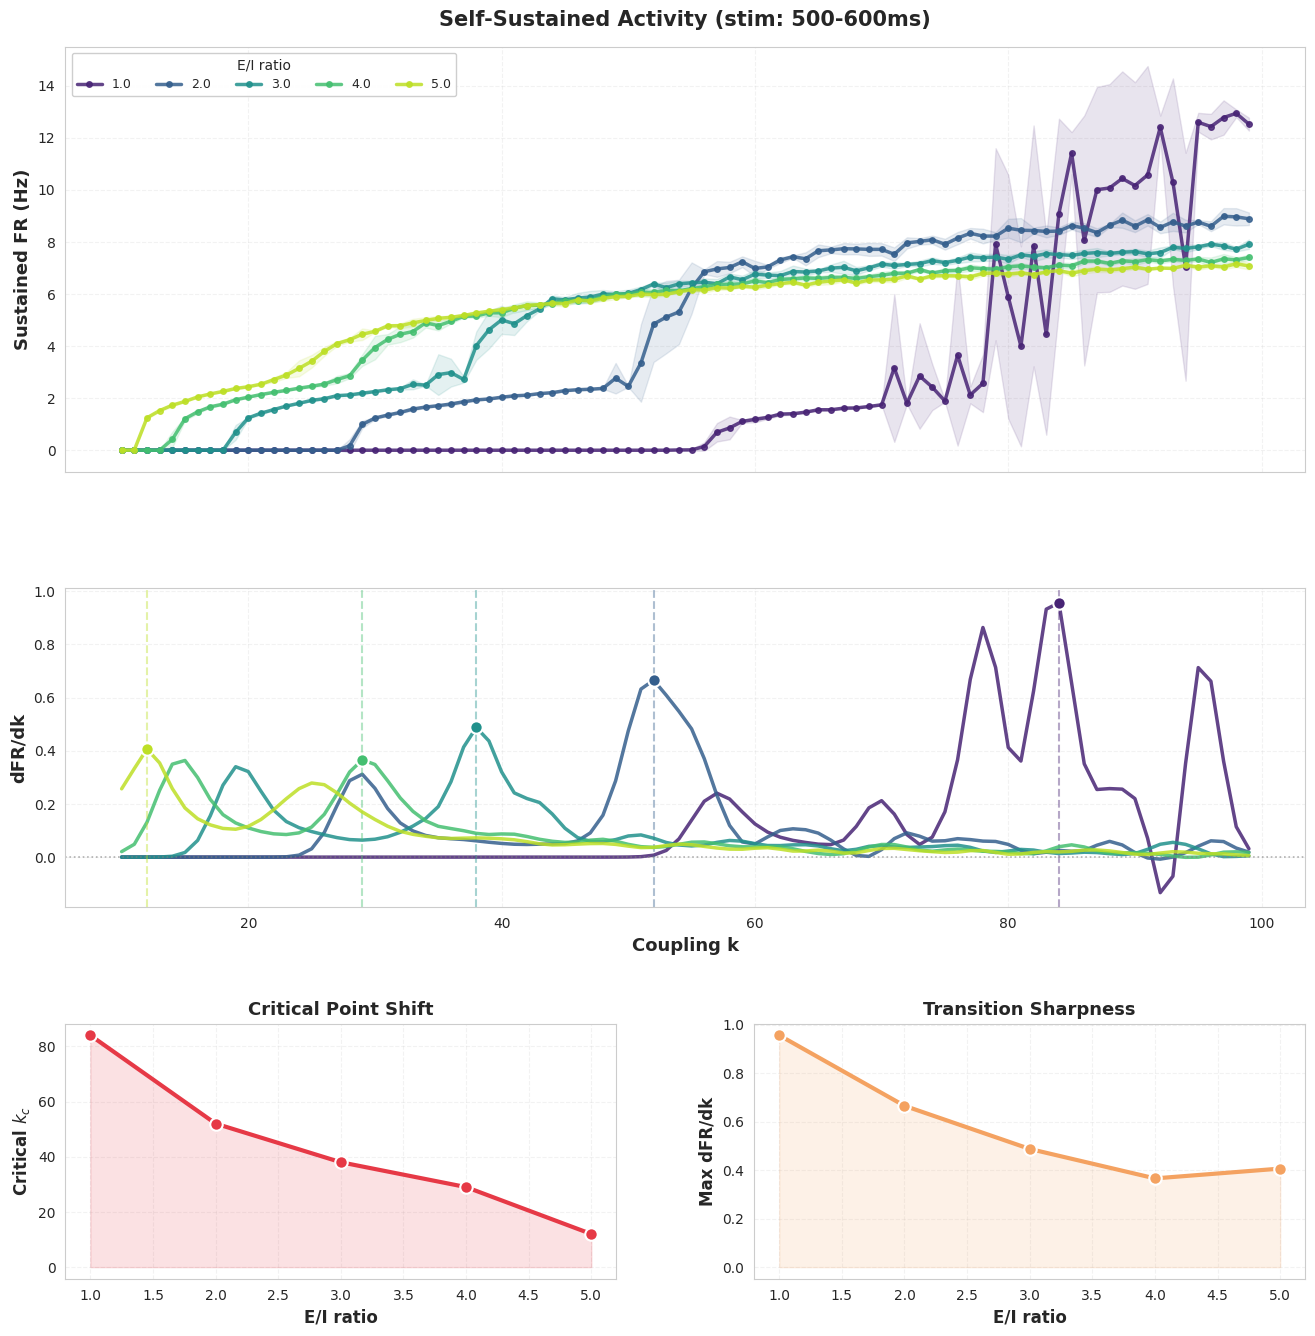

   ratio   k_c  sensitivity  variance
0    1.0  84.0     0.956500  4.800225
1    2.0  52.0     0.665517  1.491120
2    3.0  38.0     0.487598  0.782679
3    4.0  29.0     0.366046  0.451327
4    5.0  12.0     0.406503  0.305335


In [16]:
# =============================================================================
# ANÁLISIS
# =============================================================================

critical_data = []
fig = plt.figure(figsize=(16, 16))
gs = fig.add_gridspec(3, 2, height_ratios=[2, 1.5, 1.2], hspace=0.35, wspace=0.25)

ax_fr = fig.add_subplot(gs[0, :])
ax_grad = fig.add_subplot(gs[1, :], sharex=ax_fr)
ax_kc = fig.add_subplot(gs[2, 0])
ax_sens = fig.add_subplot(gs[2, 1])

colors = plt.cm.viridis(np.linspace(0.1, 0.9, len(EI_RATIOS)))

for idx, ratio in enumerate(EI_RATIOS):
    grouped = results_global[ratio]
    k_vals = sorted(grouped.keys())
    
    fr_means, fr_stds = [], []
    for k in k_vals:
        fr_trials = []
        for trial in range(N_TRIALS):
            results_dict = {'baseline': grouped[k][trial]}
            # Medir post-estímulo: [600, 2800] ms
            fr_steady = compute_steady_state_fr(results_dict, 
                                                start_ms=1500, 
                                                duration_ms=2500)
            fr_trials.append(fr_steady['baseline']['fr_A'])
        
        fr_means.append(np.mean(fr_trials))
        fr_stds.append(np.std(fr_trials))
    
    fr_smooth = gaussian_filter1d(fr_means, sigma=1.5)
    grad = np.gradient(fr_smooth, k_vals)
    
    kc_idx = np.argmax(grad)
    k_c = k_vals[kc_idx]
    
    critical_data.append({
        'ratio': ratio, 'k_c': k_c,
        'sensitivity': grad[kc_idx],
        'variance': np.max(fr_stds)
    })
    
    ax_fr.plot(k_vals, fr_means, 'o-', color=colors[idx], 
               label=f'{ratio:.1f}', linewidth=2.5, markersize=4, alpha=0.85)
    ax_fr.fill_between(k_vals, np.array(fr_means) - np.array(fr_stds),
                       np.array(fr_means) + np.array(fr_stds),
                       alpha=0.12, color=colors[idx])
    
    ax_grad.plot(k_vals, grad, '-', color=colors[idx], linewidth=2.5, alpha=0.85)
    ax_grad.axvline(k_c, color=colors[idx], linestyle='--', linewidth=1.5, alpha=0.4)
    ax_grad.scatter([k_c], [grad[kc_idx]], s=80, color=colors[idx], 
                    edgecolor='white', linewidth=1.5, zorder=5)

# Styling
ax_fr.set_ylabel('Sustained FR (Hz)', fontsize=13, fontweight='600')
ax_fr.legend(title='E/I ratio', ncol=5, fontsize=9, framealpha=0.95)
ax_fr.grid(alpha=0.25, linestyle='--')
ax_fr.set_title('Self-Sustained Activity (stim: 500-600ms)', 
                fontsize=15, fontweight='700', pad=15)
ax_fr.tick_params(labelbottom=False)

ax_grad.axhline(0, color='gray', linestyle=':', linewidth=1.2, alpha=0.6)
ax_grad.set_xlabel('Coupling k', fontsize=13, fontweight='600')
ax_grad.set_ylabel('dFR/dk', fontsize=13, fontweight='600')
ax_grad.grid(alpha=0.25, linestyle='--')

crit_df = pd.DataFrame(critical_data)

ax_kc.plot(crit_df['ratio'], crit_df['k_c'], 'o-', 
           color='#E63946', linewidth=3, markersize=9, 
           markeredgecolor='white', markeredgewidth=1.5)
ax_kc.fill_between(crit_df['ratio'], crit_df['k_c'], alpha=0.15, color='#E63946')
ax_kc.set_xlabel('E/I ratio', fontsize=12, fontweight='600')
ax_kc.set_ylabel('Critical $k_c$', fontsize=12, fontweight='600')
ax_kc.set_title('Critical Point Shift', fontsize=13, fontweight='700')
ax_kc.grid(alpha=0.25)

ax_sens.plot(crit_df['ratio'], crit_df['sensitivity'], 'o-',
             color='#F4A261', linewidth=3, markersize=9,
             markeredgecolor='white', markeredgewidth=1.5)
ax_sens.fill_between(crit_df['ratio'], crit_df['sensitivity'], 
                     alpha=0.15, color='#F4A261')
ax_sens.set_xlabel('E/I ratio', fontsize=12, fontweight='600')
ax_sens.set_ylabel('Max dFR/dk', fontsize=12, fontweight='600')
ax_sens.set_title('Transition Sharpness', fontsize=13, fontweight='700')
ax_sens.grid(alpha=0.25)

plt.savefig('ei_ratio_sustained.png', dpi=300, bbox_inches='tight')
plt.show()

print(crit_df)

E/I ratio = 1.00


SUCCESS  | src.two_populations.model:__init__:45 - Network initialized with seeds: {'trial': 0, 'fixed_seed_A': 99, 'fixed_seed_B': 101, 'fixed_seed_common': 100, 'variable_common_current': 200, 'variable_A_current': 200, 'variable_B_current': 203}
SUCCESS  | src.two_populations.model:__init__:45 - Network initialized with seeds: {'trial': 1, 'fixed_seed_A': 99, 'fixed_seed_B': 101, 'fixed_seed_common': 100, 'variable_common_current': 204, 'variable_A_current': 204, 'variable_B_current': 207}
SUCCESS  | src.two_populations.model:__init__:45 - Network initialized with seeds: {'trial': 1, 'fixed_seed_A': 99, 'fixed_seed_B': 101, 'fixed_seed_common': 100, 'variable_common_current': 204, 'variable_A_current': 204, 'variable_B_current': 207}
SUCCESS  | src.two_populations.model:__init__:45 - Network initialized with seeds: {'trial': 0, 'fixed_seed_A': 99, 'fixed_seed_B': 101, 'fixed_seed_common': 100, 'variable_common_current': 200, 'variable_A_current': 200, 'variable_B_current': 203}
SUCC

E/I ratio = 3.00


SUCCESS  | src.two_populations.model:__init__:45 - Network initialized with seeds: {'trial': 1, 'fixed_seed_A': 99, 'fixed_seed_B': 101, 'fixed_seed_common': 100, 'variable_common_current': 204, 'variable_A_current': 204, 'variable_B_current': 207}
SUCCESS  | src.two_populations.model:__init__:45 - Network initialized with seeds: {'trial': 0, 'fixed_seed_A': 99, 'fixed_seed_B': 101, 'fixed_seed_common': 100, 'variable_common_current': 200, 'variable_A_current': 200, 'variable_B_current': 203}
SUCCESS  | src.two_populations.model:__init__:45 - Network initialized with seeds: {'trial': 0, 'fixed_seed_A': 99, 'fixed_seed_B': 101, 'fixed_seed_common': 100, 'variable_common_current': 200, 'variable_A_current': 200, 'variable_B_current': 203}
SUCCESS  | src.two_populations.model:__init__:45 - Network initialized with seeds: {'trial': 1, 'fixed_seed_A': 99, 'fixed_seed_B': 101, 'fixed_seed_common': 100, 'variable_common_current': 204, 'variable_A_current': 204, 'variable_B_current': 207}
SUCC

E/I ratio = 5.00


SUCCESS  | src.two_populations.model:__init__:45 - Network initialized with seeds: {'trial': 0, 'fixed_seed_A': 99, 'fixed_seed_B': 101, 'fixed_seed_common': 100, 'variable_common_current': 200, 'variable_A_current': 200, 'variable_B_current': 203}
SUCCESS  | src.two_populations.model:__init__:45 - Network initialized with seeds: {'trial': 1, 'fixed_seed_A': 99, 'fixed_seed_B': 101, 'fixed_seed_common': 100, 'variable_common_current': 204, 'variable_A_current': 204, 'variable_B_current': 207}
SUCCESS  | src.two_populations.model:__init__:45 - Network initialized with seeds: {'trial': 1, 'fixed_seed_A': 99, 'fixed_seed_B': 101, 'fixed_seed_common': 100, 'variable_common_current': 204, 'variable_A_current': 204, 'variable_B_current': 207}
SUCCESS  | src.two_populations.model:__init__:45 - Network initialized with seeds: {'trial': 0, 'fixed_seed_A': 99, 'fixed_seed_B': 101, 'fixed_seed_common': 100, 'variable_common_current': 200, 'variable_A_current': 200, 'variable_B_current': 203}
SUCC

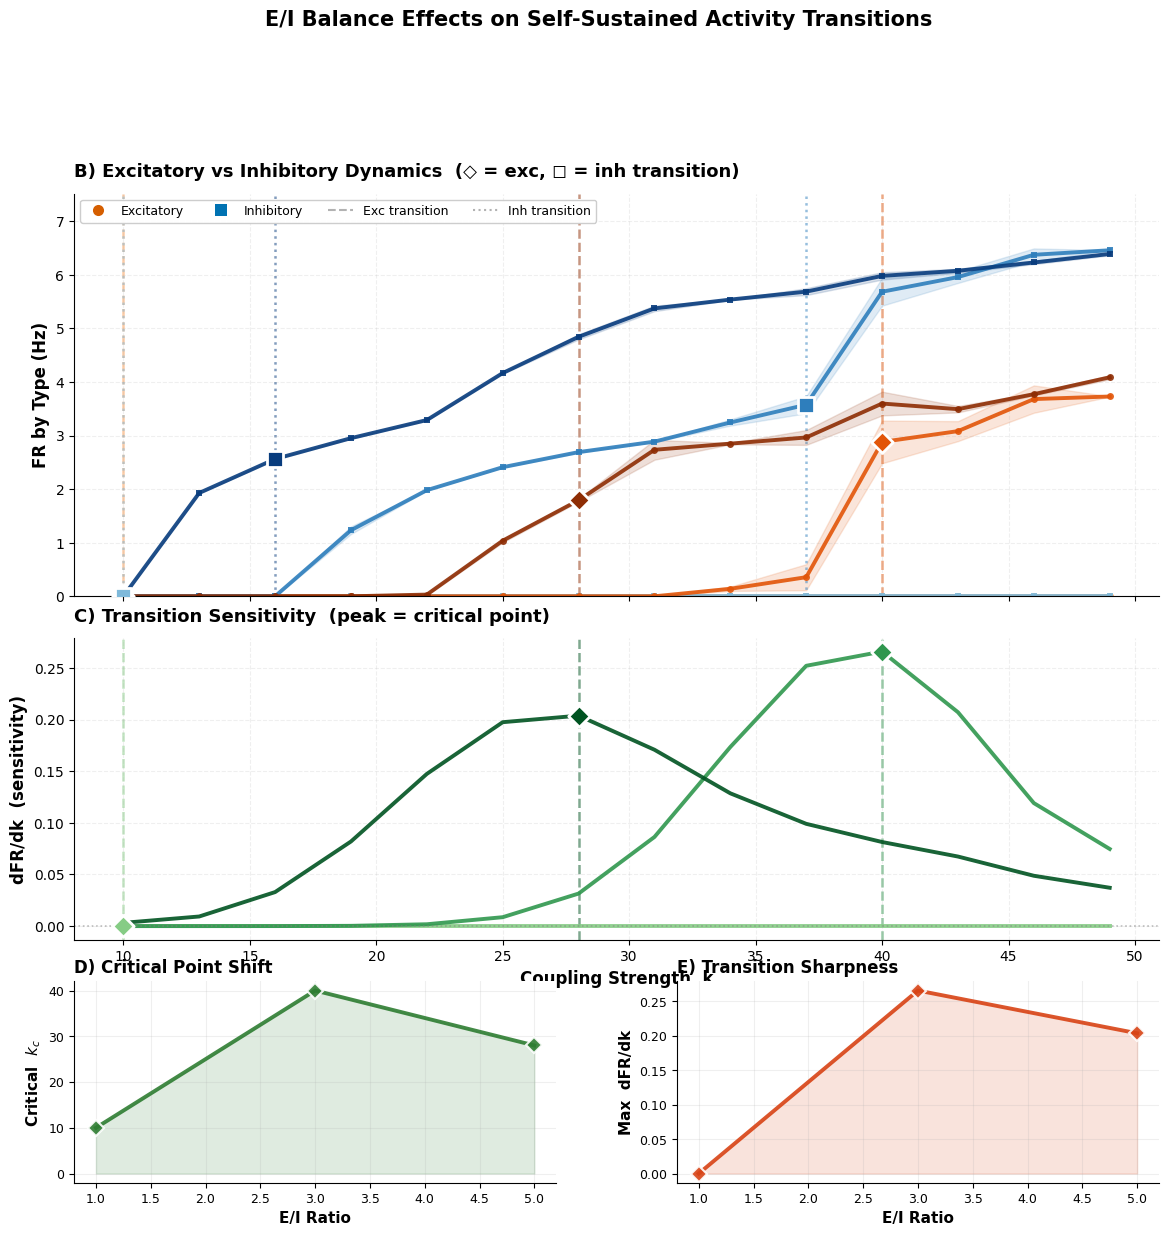


Critical Points Summary:
 ratio  k_c  sensitivity  variance  k_c_exc  k_c_inh
   1.0 10.0     0.000000  0.000000     10.0     10.0
   3.0 40.0     0.265806  0.398333     40.0     37.0
   5.0 28.0     0.203745  0.221667     28.0     16.0


In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict
from scipy.ndimage import gaussian_filter1d
import multiprocessing as mp
from functools import partial
from src.two_populations.model import IzhikevichNetwork
from src.two_populations.metrics import analyze_simulation_results
from brian2 import *

# =============================================================================
# CÁLCULO DE FR POR TIPO NEURONAL
# =============================================================================

def compute_steady_state_fr_by_type(results_dict, start_ms=1500, duration_ms=1000):
    """Calcula FR separado para excitatorias e inhibitorias"""
    fr_stats = {}
    
    for condition, results in results_dict.items():
        # Máscara temporal
        t_mask = (results['spike_times']/ms >= start_ms) & \
                 (results['spike_times']/ms < start_ms + duration_ms)
        
        spikes_in_window = results['spike_indices'][t_mask]
        Ne = results['Ne']
        Ni = results['Ni']
        
        # Contar por tipo
        n_exc = np.sum(spikes_in_window < Ne)
        n_inh = np.sum(spikes_in_window >= Ne)
        
        # FR en Hz
        window_s = duration_ms / 1000
        fr_exc = n_exc / (Ne * window_s)
        fr_inh = n_inh / (Ni * window_s)
        
        fr_stats[condition] = {
            'fr_exc': fr_exc,
            'fr_inh': fr_inh,
            'window_start_ms': start_ms,
            'window_duration_ms': duration_ms
        }
    
    return fr_stats

    
def run_single_k_trial(args, sim_config, network_params):
    """Worker que retorna datos completos para análisis por tipo"""
    k_factor, trial = args
    from brian2 import start_scope
    
    start_scope()
    
    network = IzhikevichNetwork(
        dt_val=sim_config['dt_ms'],
        T_total=sim_config['T_ms'],
        fixed_seed=100,
        variable_seed=200 + trial,
        trial=trial
    )
    
    params = network_params['pop_A'].copy()
    
    pop_A = network.create_population2('A', **params)
    network.setup_monitors(['A'], record_v_dt=0.5, sample_fraction=0.5)
    results = network.run_simulation()
    
    full_result = analyze_simulation_results(
        spike_mon_A=results['A']['spike_monitor'],
        spike_mon_B=None,
        N=params['Ne'] + params['Ni'],
        condition_name=f"k={k_factor:.3f}_trial{trial}",
        warmup=sim_config['warmup_ms'],
        state_monitors={'A': network.monitors['A']},
        signal_mode='lfp',
        T_total=sim_config['T_ms']
    )
    
    return {
        'k_factor': k_factor,
        'trial': trial,
        'time_series': full_result['time_series'],
        'spike_times': results['A']['spike_monitor'].t[:],
        'spike_indices': results['A']['spike_monitor'].i[:],
        'Ne': params['Ne'],  
        'Ni': params['Ni'],
        'gamma_power': full_result['power_A']['gamma_power'],
    }

# =============================================================================
# CONFIGURACIÓN
# =============================================================================

EI_RATIOS = [1.0,3.0,5.0]
N_TRIALS = 2
K_VALUES = np.arange(10, 50, 3.0)

Ni, Ne = 800, 200

SIM_CONFIG = {'dt_ms': 0.1, 'T_ms': 3000, 'warmup_ms': 500}

NETWORK_PARAMS = {
    'pop_A': {
        'Ne': Ne, 'Ni': Ni,
        'noise_exc': 0.88, 
        'noise_inh': 0.60,
        'p_intra': 0.1, 
        'delay': 0.0,
        'rate_hz': 10.0,
        'stim_start_ms': 500.0, 
        'stim_duration_ms': 100.0,
        'stim_base': 0.0, 
        'stim_elevated': 3.0
    }
}

# =============================================================================
# EJECUCIÓN
# =============================================================================

results_global = {}

for ratio in EI_RATIOS:
    print(f"E/I ratio = {ratio:.2f}")
    
    def run_ratio_trial(args):
        k_factor, trial = args
        network_params_ratio = {'pop_A': NETWORK_PARAMS['pop_A'].copy()}
        network_params_ratio['pop_A']['k_inh'] = k_factor * ratio
        network_params_ratio['pop_A']['k_exc'] = k_factor
        
        return run_single_k_trial((k_factor, trial),
                                  sim_config=SIM_CONFIG,
                                  network_params=network_params_ratio)
    
    k_trial_pairs = [(k, t) for k in K_VALUES for t in range(N_TRIALS)]
    
    with mp.Pool(processes=mp.cpu_count()-1) as pool:
        results_list = pool.map(run_ratio_trial, k_trial_pairs)
    
    grouped = defaultdict(dict)
    for r in results_list:
        grouped[r['k_factor']][r['trial']] = r
    results_global[ratio] = grouped

# =============================================================================
# ANÁLISIS Y VISUALIZACIÓN
# =============================================================================

critical_data = []

# Figura con 3 paneles alineados verticalmente + 2 resumen
fig = plt.figure(figsize=(14, 16))
gs = fig.add_gridspec(4, 2, height_ratios=[2.0, 1.5, 1, 1], 
                      hspace=0.15, wspace=0.25)

ax_fr_type = fig.add_subplot(gs[0, :], sharex=ax_fr)
ax_grad = fig.add_subplot(gs[1, :], sharex=ax_fr)
ax_kc = fig.add_subplot(gs[2, 0])
ax_sens = fig.add_subplot(gs[2, 1])

# Colores distinguibles
colors_exc = plt.cm.Oranges(np.linspace(0.45, 0.95, len(EI_RATIOS)))
colors_inh = plt.cm.Blues(np.linspace(0.45, 0.95, len(EI_RATIOS)))
colors_total = plt.cm.Greens(np.linspace(0.45, 0.95, len(EI_RATIOS)))

for idx, ratio in enumerate(EI_RATIOS):
    grouped = results_global[ratio]
    k_vals = sorted(grouped.keys())
    
    # Calcular FR total y por tipo
    fr_means, fr_stds = [], []
    fr_exc_means, fr_exc_stds = [], []
    fr_inh_means, fr_inh_stds = [], []
    
    for k in k_vals:
        fr_trials, fr_exc_trials, fr_inh_trials = [], [], []
        
        for trial in range(N_TRIALS):
            results_dict = {'baseline': grouped[k][trial]}
            
            # FR total (original)
            fr_steady = compute_steady_state_fr_by_type(
                results_dict, start_ms=1500, duration_ms=1500
            )
            
            fr_exc_trials.append(fr_steady['baseline']['fr_exc'])
            fr_inh_trials.append(fr_steady['baseline']['fr_inh'])
            fr_trials.append(fr_steady['baseline']['fr_exc'])  # Para gradiente
        
        fr_means.append(np.mean(fr_trials))
        fr_stds.append(np.std(fr_trials))
        fr_exc_means.append(np.mean(fr_exc_trials))
        fr_exc_stds.append(np.std(fr_exc_trials))
        fr_inh_means.append(np.mean(fr_inh_trials))
        fr_inh_stds.append(np.std(fr_inh_trials))
    
    # Panel 1: FR total con detección de transición mejorada
    fr_smooth = gaussian_filter1d(fr_means, sigma=1.5)
    fr_exc_smooth = gaussian_filter1d(fr_exc_means, sigma=1.5)
    fr_inh_smooth = gaussian_filter1d(fr_inh_means, sigma=1.5)
    
    grad = np.gradient(fr_smooth, k_vals)
    grad_exc = np.gradient(fr_exc_smooth, k_vals)
    grad_inh = np.gradient(fr_inh_smooth, k_vals)
    
    # Punto crítico: máxima pendiente en FR total
    kc_idx = np.argmax(grad)
    k_c = k_vals[kc_idx]
    
    # Almacenar datos
    critical_data.append({
        'ratio': ratio, 'k_c': k_c,
        'sensitivity': grad[kc_idx],
        'variance': np.max(fr_stds),
        'k_c_exc': k_vals[np.argmax(grad_exc)],
        'k_c_inh': k_vals[np.argmax(grad_inh)]
    })
    
    # Panel 1: FR total con marcadores de transición
    ax_fr.plot(k_vals, fr_means, 'o-', color=colors_total[idx], 
               label=f'E/I={ratio:.1f}', linewidth=2.8, markersize=5, alpha=0.9,
               markerfacecolor=colors_total[idx], markeredgewidth=0)
    ax_fr.fill_between(k_vals, np.array(fr_means) - np.array(fr_stds),
                       np.array(fr_means) + np.array(fr_stds),
                       alpha=0.15, color=colors_total[idx])
    
    # Línea vertical en k_c
    ax_fr.axvline(k_c, color=colors_total[idx], linestyle='--', 
                  linewidth=1.8, alpha=0.5, zorder=1)
    ax_fr.scatter([k_c], [fr_means[kc_idx]], s=120, color=colors_total[idx],
                  edgecolor='white', linewidth=2, zorder=10, marker='D')
    
    # Panel 2: FR por tipo con marcadores de transición
    kc_exc_idx = np.argmax(grad_exc)
    kc_inh_idx = np.argmax(grad_inh)
    
    # Curvas excitatorias
    ax_fr_type.plot(k_vals, fr_exc_means, 'o-', color=colors_exc[idx],
                    linewidth=2.8, markersize=5, alpha=0.9,
                    markerfacecolor=colors_exc[idx], markeredgewidth=0)
    ax_fr_type.fill_between(k_vals, 
                            np.array(fr_exc_means) - np.array(fr_exc_stds),
                            np.array(fr_exc_means) + np.array(fr_exc_stds),
                            alpha=0.15, color=colors_exc[idx])
    ax_fr_type.axvline(k_vals[kc_exc_idx], color=colors_exc[idx], 
                       linestyle='--', linewidth=1.8, alpha=0.5, zorder=1)
    ax_fr_type.scatter([k_vals[kc_exc_idx]], [fr_exc_means[kc_exc_idx]], 
                       s=120, color=colors_exc[idx], edgecolor='white', 
                       linewidth=2, zorder=10, marker='D')
    
    # Curvas inhibitorias
    ax_fr_type.plot(k_vals, fr_inh_means, 's-', color=colors_inh[idx],
                    linewidth=2.8, markersize=5, alpha=0.9,
                    markerfacecolor=colors_inh[idx], markeredgewidth=0)
    ax_fr_type.fill_between(k_vals,
                            np.array(fr_inh_means) - np.array(fr_inh_stds),
                            np.array(fr_inh_means) + np.array(fr_inh_stds),
                            alpha=0.15, color=colors_inh[idx])
    ax_fr_type.axvline(k_vals[kc_inh_idx], color=colors_inh[idx],
                       linestyle=':', linewidth=1.8, alpha=0.5, zorder=1)
    ax_fr_type.scatter([k_vals[kc_inh_idx]], [fr_inh_means[kc_inh_idx]],
                       s=120, color=colors_inh[idx], edgecolor='white',
                       linewidth=2, zorder=10, marker='s')
    
    # Panel 3: Gradiente con marcadores de transición
    ax_grad.plot(k_vals, grad, '-', color=colors_total[idx], 
                 linewidth=2.8, alpha=0.9)
    ax_grad.axvline(k_c, color=colors_total[idx], linestyle='--', 
                    linewidth=1.8, alpha=0.5, zorder=1)
    ax_grad.scatter([k_c], [grad[kc_idx]], s=120, color=colors_total[idx], 
                    edgecolor='white', linewidth=2, zorder=10, marker='D')

# Styling Panel 2: FR por tipo
from matplotlib.lines import Line2D
legend_elements = [
    Line2D([0], [0], color='none', marker='o', markersize=8, 
           markerfacecolor='#D55E00', label='Excitatory', markeredgewidth=0),
    Line2D([0], [0], color='none', marker='s', markersize=8,
           markerfacecolor='#0072B2', label='Inhibitory', markeredgewidth=0),
    Line2D([0], [0], color='gray', linestyle='--', linewidth=1.5,
           label='Exc transition', alpha=0.6),
    Line2D([0], [0], color='gray', linestyle=':', linewidth=1.5,
           label='Inh transition', alpha=0.6)
]
ax_fr_type.set_ylabel('FR by Type (Hz)', fontsize=12, fontweight='600')
ax_fr_type.legend(handles=legend_elements, ncol=4, fontsize=9, 
                  framealpha=0.98, loc='upper left')
ax_fr_type.grid(alpha=0.2, linestyle='--', linewidth=0.8)
ax_fr_type.set_title('B) Excitatory vs Inhibitory Dynamics  (◇ = exc, ◻ = inh transition)', 
                     fontsize=13, fontweight='700', pad=12, loc='left')
ax_fr_type.tick_params(labelbottom=False, labelsize=10)
ax_fr_type.spines['top'].set_visible(False)
ax_fr_type.spines['right'].set_visible(False)

# Styling Panel 3: Gradiente
ax_grad.axhline(0, color='gray', linestyle=':', linewidth=1.2, alpha=0.5)
ax_grad.set_xlabel('Coupling Strength  k', fontsize=12, fontweight='600')
ax_grad.set_ylabel('dFR/dk  (sensitivity)', fontsize=12, fontweight='600')
ax_grad.grid(alpha=0.2, linestyle='--', linewidth=0.8)
ax_grad.set_title('C) Transition Sensitivity  (peak = critical point)', 
                  fontsize=13, fontweight='700', pad=12, loc='left')
ax_grad.tick_params(labelsize=10)
ax_grad.spines['top'].set_visible(False)
ax_grad.spines['right'].set_visible(False)

# Alinear límites y-axis entre paneles relacionados
fr_max = max(ax_fr.get_ylim()[1], ax_fr_type.get_ylim()[1])
ax_fr.set_ylim([0, fr_max * 1.05])
ax_fr_type.set_ylim([0, fr_max * 1.05])

# Panels 4-5: Resumen
crit_df = pd.DataFrame(critical_data)

ax_kc.plot(crit_df['ratio'], crit_df['k_c'], 'D-', 
           color='#2E7D32', linewidth=2.8, markersize=8, 
           markeredgecolor='white', markeredgewidth=1.5, alpha=0.9)
ax_kc.fill_between(crit_df['ratio'], crit_df['k_c'], alpha=0.15, color='#2E7D32')
ax_kc.set_xlabel('E/I Ratio', fontsize=11, fontweight='600')
ax_kc.set_ylabel('Critical  $k_c$', fontsize=11, fontweight='600')
ax_kc.set_title('D) Critical Point Shift', fontsize=12, fontweight='700', loc='left')
ax_kc.grid(alpha=0.2, linewidth=0.8)
ax_kc.tick_params(labelsize=9)
ax_kc.spines['top'].set_visible(False)
ax_kc.spines['right'].set_visible(False)

ax_sens.plot(crit_df['ratio'], crit_df['sensitivity'], 'D-',
             color='#D84315', linewidth=2.8, markersize=8,
             markeredgecolor='white', markeredgewidth=1.5, alpha=0.9)
ax_sens.fill_between(crit_df['ratio'], crit_df['sensitivity'], 
                     alpha=0.15, color='#D84315')
ax_sens.set_xlabel('E/I Ratio', fontsize=11, fontweight='600')
ax_sens.set_ylabel('Max  dFR/dk', fontsize=11, fontweight='600')
ax_sens.set_title('E) Transition Sharpness', fontsize=12, fontweight='700', loc='left')
ax_sens.grid(alpha=0.2, linewidth=0.8)
ax_sens.tick_params(labelsize=9)
ax_sens.spines['top'].set_visible(False)
ax_sens.spines['right'].set_visible(False)

plt.suptitle('E/I Balance Effects on Self-Sustained Activity Transitions', 
             fontsize=15, fontweight='800', y=0.995)

plt.savefig('ei_ratio_by_type.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

print("\nCritical Points Summary:")
print(crit_df.to_string(index=False))

In [ ]:
# =============================================================================
# MÉTRICAS DE CRITICALIDAD POR RATIO (corregido)
# =============================================================================
critical_data = []
plt.figure(figsize=(10,12))
for ratio, grouped in results_global.items():
    k_vals = sorted(grouped.keys())
    fr_means, fr_stds, taus = [], [], []
    
    for k in k_vals:
        fr_trials = []
        tau_trials = []
        for trial in range(N_TRIALS):
            results_dict = {'baseline': grouped[k][trial]}
            fr_steady = compute_steady_state_fr(results_dict,
                                                start_ms=1500,
                                                duration_ms=1000)
            fr_trials.append(fr_steady['baseline']['fr_A'])
            
            # --- manejo robusto de tau ---
            tr = grouped[k][trial]
            tau_candidates = []
            if 'int_A' in tr and isinstance(tr['int_A'], dict):
                tau_candidates.append(tr['int_A'].get('tau', np.nan))
            if 'int_B' in tr and isinstance(tr['int_B'], dict):
                tau_candidates.append(tr['int_B'].get('tau', np.nan))
            
            if len(tau_candidates) > 0:
                tau_val = np.nanmean(tau_candidates)
            else:
                tau_val = np.nan  # si no existe, marcar como nan
            tau_trials.append(tau_val)
            # -----------------------------
        
        fr_means.append(np.mean(fr_trials))
        fr_stds.append(np.std(fr_trials))
        taus.append(np.nanmean(tau_trials))
    
    fr_means_smooth = gaussian_filter1d(fr_means, sigma=1.5)
    grad = np.gradient(fr_means_smooth, k_vals)
    
    # Detectar punto crítico k_c (donde FR sale de 0 o grad máx)
    kc_idx = np.argmax(grad)
    k_c = k_vals[kc_idx]
    
    critical_data.append({
        'ratio': ratio,
        'k_c': k_c,
        'grad_max': np.max(grad),
        'var_max': np.max(fr_stds),
        'mean_tau_at_kc': taus[kc_idx]
    })
    
    # Plot resumen individual
    plt.subplot(2,1,1)
    plt.plot(k_vals, fr_means, 'o-', label=f'FR mean - Ratio = {ratio}')
    plt.fill_between(k_vals,
                     np.array(fr_means)-np.array(fr_stds),
                     np.array(fr_means)+np.array(fr_stds),
                     alpha=0.2, color='steelblue')
    
    plt.subplot(2,1,2)
    plt.plot(k_vals, grad/np.max(grad)*np.max(fr_means), '--', label=f'Scaled gradient: {ratio}')
    #plt.axvline(k_c, color='crimson', ls='--', label=f'$k_c$={k_c:.2f}')

plt.subplot(2,1,1)
plt.title(f'FR vs k')
plt.xlabel('Coupling k')
plt.ylabel('Firing rate (Hz)')
plt.legend()

plt.subplot(2,1,2)
plt.title(f'Scaled gradient vs k')
plt.xlabel('Coupling k')
plt.ylabel('Scaled gradient')
plt.legend()

plt.tight_layout()
plt.show()

critical_df = pd.DataFrame(critical_data)

print(critical_df.sort_values('ratio'))
plt.figure(figsize=(6,4))
plt.plot(critical_df['ratio'], critical_df['k_c'], 'o-', lw=2)
plt.xlabel('E/I ratio')
plt.ylabel('Critical coupling k_c')
plt.title('Critical point shift with E/I balance')
plt.show()


NameError: name 'results_global' is not defined

<Figure size 1000x1200 with 0 Axes>

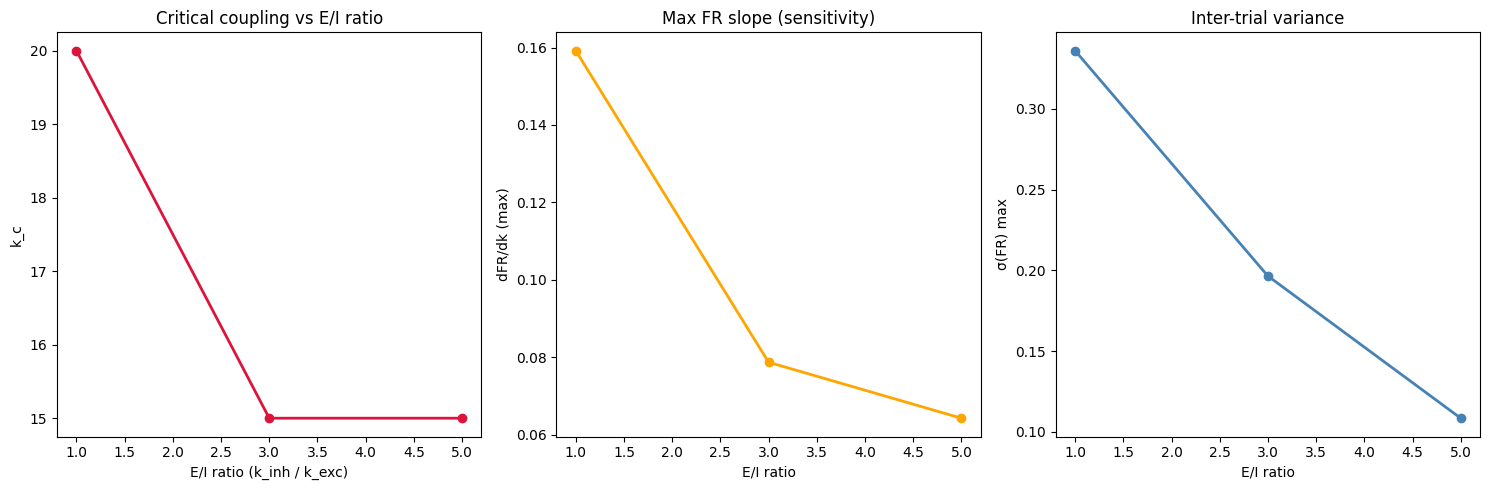

NameError: name 'results_global' is not defined

In [ ]:
# =============================================================================
# VISUALIZACIÓN DEL MAPA DE CRITICALIDAD
# =============================================================================
fig, axes = plt.subplots(1, 3, figsize=(15,5))

# k_c vs ratio
axes[0].plot(critical_df['ratio'], critical_df['k_c'], 'o-', color='crimson', lw=2)
axes[0].set_title('Critical coupling vs E/I ratio')
axes[0].set_xlabel('E/I ratio (k_inh / k_exc)')
axes[0].set_ylabel('k_c')

# pendiente máxima
axes[1].plot(critical_df['ratio'], critical_df['grad_max'], 'o-', color='orange', lw=2)
axes[1].set_title('Max FR slope (sensitivity)')
axes[1].set_xlabel('E/I ratio')
axes[1].set_ylabel('dFR/dk (max)')

# varianza inter-trial
axes[2].plot(critical_df['ratio'], critical_df['var_max'], 'o-', color='steelblue', lw=2)
axes[2].set_title('Inter-trial variance')
axes[2].set_xlabel('E/I ratio')
axes[2].set_ylabel('σ(FR) max')

plt.tight_layout()
plt.show()

# Opcional: heatmap 2D si quieres visualizar FR(k, ratio)
import seaborn as sns
fr_matrix_all = []
for ratio, grouped in results_global.items():
    k_vals = sorted(grouped.keys())
    fr_mean = [np.mean([compute_steady_state_fr({'baseline': grouped[k][t]}, 
                                             start_ms=1500, duration_ms=1000)['baseline']['fr_A']
                    for t in range(N_TRIALS)]) for k in k_vals]
    fr_matrix_all.append(fr_mean)

sns.heatmap(fr_matrix_all, cmap='RdYlBu_r',
            xticklabels=np.round(k_vals[::4],1),
            yticklabels=EI_RATIOS,
            cbar_kws={'label': 'FR (Hz)'})
plt.xlabel('Coupling k')
plt.ylabel('E/I ratio')
plt.title('FR landscape (E/I ratio vs k)')
plt.show()


In [ ]:
# =============================================================================
# BARRIDO FINAL: mapa de criticalidad E/I con beta, tau y rango dinámico
# =============================================================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict
from scipy.ndimage import gaussian_filter1d
from scipy.stats import linregress
from functools import partial
import multiprocessing as mp
from tqdm.notebook import tqdm
from scipy.signal import welch
from src.two_populations.model import IzhikevichNetwork
from src.two_populations.model import IzhikevichNetwork
import numpy as np
from src.two_populations.model import IzhikevichNetwork
from src.two_populations.metrics import analyze_simulation_results, print_network_statistics_table
from src.two_populations.plots.dashboard_plots import plot_connectivity_dashboard, plot_population_dashboard
from brian2 import * 

def run_single_k_trial(args, sim_config, network_params):
    """Worker que retorna time_series para post-procesamiento"""
    k_factor, trial = args
    from brian2 import start_scope
    
    start_scope()
    
    network = IzhikevichNetwork(
        dt_val=sim_config['dt_ms'],
        T_total=sim_config['T_ms'],
        fixed_seed=100,
        variable_seed=200 + trial,
        trial=trial
    )
    
    params = network_params['pop_A'].copy()
    # params['k_exc'] = k_factor
    # params['k_inh'] = k_factor * 1.9
    
    pop_A = network.create_population2('A', **params)
    network.setup_monitors(['A'], record_v_dt=0.5, sample_fraction=0.5)
    results = network.run_simulation()
    
    full_result = analyze_simulation_results(
        spike_mon_A=results['A']['spike_monitor'],
        spike_mon_B=None,
        N=params['Ne'] + params['Ni'],
        condition_name=f"k={k_factor:.3f}_trial{trial}",
        warmup=sim_config['warmup_ms'],
        state_monitors={'A': network.monitors['A']},
        signal_mode='lfp',
        T_total=sim_config['T_ms']
    )
    
    # Retornar estructura compatible con compute_steady_state_fr
    return {
        'k_factor': k_factor,
        'trial': trial,
        'time_series': full_result['time_series'],  # ← Incluir
        'gamma_power': full_result['power_A']['gamma_power'],
    }


# -------------------------
# Configuración del experimento
# -------------------------
EI_RATIOS = [1.0, 2.0, 3.0, 4.0, 5.0]    # relaciones k_inh / k_exc a barrer , 6.0, 7.0
N_TRIALS = 1                           # aumentar para robustez (5-10 recomendado)
K_STEP = 5.0                             # resolución en k
K_VALUES = np.arange(0.0, 100.0 + K_STEP, K_STEP)

SIM_CONFIG = {
    'dt_ms': 0.1,
    'T_ms': 3000,
    'warmup_ms': 500
}

NETWORK_PARAMS = {
    'pop_A': {
        'Ne': 800, 'Ni': 200,
        'noise_exc': 0.88, 
        'noise_inh': 0.6,
        'p_intra': 0.1, 
        'delay': 0.0,
        'rate_hz':10.0,
        'stim_base':0.0, 'stim_elevated':3.0,
        'stim_start_ms':500.0, 'stim_duration_ms':100.0
    }
}

# Parámetros para el experimento de rango dinámico (se hará alrededor de k_c)
STIM_VALUES = np.logspace(-2, 1.0, 5)    # valores de stim_elevated (log spaced, ajusta según escala)
DYN_RANGE_FRAC = (0.1, 0.9)              # percentiles para definir dynamic range (S10, S90)

# Directorio / guardado (opcional)
SAVE_CSV = True
OUT_PREFIX = "final_sweep_results"

# -------------------------
# Funciones auxiliares (autocorr tau y spectral beta)
# -------------------------
def compute_power_spectral_exponent(signal, fs, fmin=1.0, fmax=200.0):
    """Welch + ajuste lineal en log-log para estimar beta (1/f^beta)."""
    signal = np.asarray(signal)
    if len(signal) < 16:
        return np.nan, None, None
    f, Pxx = welch(signal, fs=fs, nperseg=min(len(signal)//2, 2048))
    mask = (f >= fmin) & (f <= min(fmax, f.max())) & (Pxx > 0)
    if np.sum(mask) < 3:
        return np.nan, f, Pxx
    slope, intercept, r, p, se = linregress(np.log10(f[mask]), np.log10(Pxx[mask]))
    beta = -slope
    return beta, f, Pxx

def compute_autocorr_time(signal, dt_ms):
    """Estimate integrated autocorrelation time tau (ms) using autocorrelation integral.
       tau = dt * sum_{t>=0} rho(t)  (rho normalized => rho(0)=1)
       We integrate until correlation becomes negative or full signal.
    """
    x = np.asarray(signal)
    x = x - np.mean(x)
    n = len(x)
    if n < 4 or np.allclose(x, 0):
        return np.nan
    # biased autocorrelation (fast)
    corr = np.correlate(x, x, mode='full')
    corr = corr[corr.size//2:]  # from lag 0 to end
    corr = corr / corr[0]
    # integrate until first crossing to zero (or entire)
    positive_mask = corr > 0
    if not np.any(positive_mask[1:]):  # no positive tail beyond lag 0
        return dt_ms
    # integrate up to first negative or full length
    first_neg = np.where(corr[1:] <= 0)[0]
    if first_neg.size > 0:
        end_idx = first_neg[0] + 1
    else:
        end_idx = len(corr)-1
    tau = dt_ms * np.sum(corr[:end_idx+1])
    return float(tau)

# -------------------------
# Verificador de parámetros: asegura que el ratio se aplica
# -------------------------
def debug_check_params(network_params, show_examples=(10, 50)):
    p = network_params['pop_A']
    for k in show_examples:
        pcopy = p.copy()
        pcopy['k_exc'] = k
        # assume external code sets k_inh appropriately before calling run
        # show what we'd expect:
        print(f"[DEBUG expect] k_exc={k}, k_inh (if set externally) = {pcopy.get('k_inh', 'NOT SET')}")

# -------------------------
# Worker que llama a run_single_k_trial esperando network_params con k_exc/k_inh ya fijados
# -------------------------
def run_worker(args, sim_config, network_params):
    """Wrapper simple para mp.Pool. args = (k, trial)."""
    k_val, trial = args
    # Make a deep-ish copy to avoid cross-talk
    netp = {'pop_A': network_params['pop_A'].copy()}
    # Ensure k_exc/k_inh are present for logging (they should be set by caller)
    # run_single_k_trial expects (k, trial) in first arg as before
    res = run_single_k_trial((k_val, trial), sim_config=sim_config, network_params=netp)
    # Basic sanity: attach effective params used (if available)
    res['_k_exc_used'] = netp['pop_A'].get('k_exc', None)
    res['_k_inh_used'] = netp['pop_A'].get('k_inh', None)
    return res

# -------------------------
# MAIN SWEEP: por cada ratio, correr K_VALUES × trials (paralelizado)
# -------------------------
results_global = {}
cpu_n = max(1, mp.cpu_count()-2)

for ratio in EI_RATIOS:
    logger.info(f"=== Ejecutando ratio E/I = {ratio} (trials={N_TRIALS}, k_step={K_STEP}) ===")
    # Build network_params copy for this ratio template
    base_net = NETWORK_PARAMS.copy()
    base_net['pop_A'] = NETWORK_PARAMS['pop_A'].copy()
    # We'll fill k_exc/k_inh per-run in run_ratio_trial below
    
    # Define local runner that injects k_exc/k_inh in the params before calling worker
    def run_ratio_trial_local(args):
        k_val, trial = args
        # copy base params and set k values
        netcopy = NETWORK_PARAMS.copy()
        netcopy['pop_A'] = NETWORK_PARAMS['pop_A'].copy()
        netcopy['pop_A']['k_exc'] = float(k_val)
        netcopy['pop_A']['k_inh'] = float(k_val * ratio)
        # call run_single_k_trial directly (it expects network_params with pop_A)
        return run_single_k_trial((k_val, trial), sim_config=SIM_CONFIG, network_params=netcopy)
    
    # prepare pairs and run in parallel
    k_trial_pairs = [(k, t) for k in K_VALUES for t in range(N_TRIALS)]
    n_proc = min(cpu_n, len(k_trial_pairs))
    with mp.Pool(processes=n_proc) as pool:
        results_list = list(tqdm(pool.imap(run_ratio_trial_local, k_trial_pairs),
                                 total=len(k_trial_pairs),
                                 desc=f"E/I={ratio}"))
    # group
    grouped = defaultdict(dict)
    for r in results_list:
        grouped[r['k_factor']][r['trial']] = r
    results_global[ratio] = grouped
    logger.info(f"Done ratio {ratio}: stored {len(grouped)} k-values")

logger.info("=== All ratios simulated ===")

# -------------------------
# Análisis: FR, gradiente, var, tau, beta por ratio
# -------------------------
critical_data = []
full_detail = {}   # store per-ratio detailed arrays for plotting later

for ratio, grouped in results_global.items():
    k_vals = sorted(grouped.keys())
    fr_means, fr_stds, taus, betas = [], [], [], []
    
    for k in k_vals:
        fr_trials = []
        tau_trials = []
        beta_trials = []
        for trial in range(N_TRIALS):
            tr = grouped[k][trial]
            # basic safety: ensure time_series present
            ts = tr.get('time_series', {})
            time = ts.get('time_fr', None)
            fr = ts.get('fr_A', None)
            if time is None or fr is None:
                fr_trials.append(0.0)
                tau_trials.append(np.nan)
                beta_trials.append(np.nan)
                continue
            fr = np.asarray(fr)
            fr_trials.append(np.mean(fr))  # simple mean used for FR mean (we also later use windowed FR)
            
            # compute autocorr tau on whole FR trace (ms)
            dt_ms = (time[1] - time[0]) if len(time) > 1 else SIM_CONFIG['dt_ms']
            tau_val = compute_autocorr_time(fr, dt_ms)
            tau_trials.append(tau_val)
            
            # compute spectral beta
            fs = 1000.0 / dt_ms
            beta_val, f_psd, Pxx = compute_power_spectral_exponent(fr - np.mean(fr), fs, fmin=1.0, fmax=200.0)
            beta_trials.append(beta_val)
        
        fr_means.append(np.mean(fr_trials))
        fr_stds.append(np.std(fr_trials))
        taus.append(np.nanmean(tau_trials))
        betas.append(np.nanmean(beta_trials))
    
    # smooth and gradient
    fr_means_smooth = gaussian_filter1d(fr_means, sigma=1.5)
    grad = np.gradient(fr_means_smooth, k_vals)
    kc_idx = int(np.argmax(grad))
    k_c = k_vals[kc_idx]
    
    critical_data.append({
        'ratio': ratio,
        'k_c': k_c,
        'grad_max': float(np.max(grad)),
        'var_max': float(np.max(fr_stds)),
        'mean_tau_at_kc': float(taus[kc_idx]) if not np.isnan(taus[kc_idx]) else np.nan,
        'beta_at_kc': float(betas[kc_idx]) if not np.isnan(betas[kc_idx]) else np.nan
    })
    
    full_detail[ratio] = {
        'k_vals': np.array(k_vals),
        'fr_means': np.array(fr_means),
        'fr_stds': np.array(fr_stds),
        'grad': np.array(grad),
        'taus': np.array(taus),
        'betas': np.array(betas),
        'kc_idx': kc_idx,
        'k_c': k_c
    }
    
    # quick plot per ratio (FR + band)
    plt.figure(figsize=(9,4))
    plt.subplot(1,2,1)
    plt.plot(k_vals, fr_means, 'o-', label=f'FR mean (ratio={ratio})')
    plt.fill_between(k_vals, np.array(fr_means)-np.array(fr_stds), np.array(fr_means)+np.array(fr_stds), alpha=0.15)
    plt.axvline(k_c, color='crimson', ls='--', label=f'k_c={k_c:.1f}')
    plt.xlabel('k'); plt.ylabel('FR (Hz)'); plt.title(f'FR vs k (ratio={ratio})'); plt.legend()
    
    plt.subplot(1,2,2)
    # plot grad scaled and tau & beta as markers
    scaled_grad = grad / np.nanmax(grad) * np.nanmax(fr_means) if np.nanmax(grad) > 0 else grad
    plt.plot(k_vals, scaled_grad, '--', label='scaled grad')
    plt.plot(k_vals, taus / np.nanmax(taus) * np.nanmax(fr_means), '-.', label='scaled tau')
    plt.scatter(k_vals, betas / (np.nanmax(betas) if np.nanmax(betas)==np.nanmax(betas) else 1.0) * np.nanmax(fr_means), s=30, label='scaled beta')
    plt.xlabel('k'); plt.title('grad / tau / beta (scaled)'); plt.legend()
    plt.tight_layout()
    plt.show()

critical_df = pd.DataFrame(critical_data).sort_values('ratio').reset_index(drop=True)
print("Critical summary:")
display(critical_df)

if SAVE_CSV:
    critical_df.to_csv(f"{OUT_PREFIX}_critical_df.csv", index=False)
    print(f"Saved {OUT_PREFIX}_critical_df.csv")

# -------------------------
# Dynamic range experiment PARALELIZADO
# -------------------------
from itertools import product

def run_stim_trial(args):
    """Worker para experimento de rango dinámico"""
    ratio, kprobe, stim, trial, sim_config, base_params = args
    from brian2 import start_scope
    start_scope()
    
    netcopy = base_params.copy()
    netcopy['pop_A'] = base_params['pop_A'].copy()
    netcopy['pop_A'].update({
        'k_exc': float(kprobe),
        'k_inh': float(kprobe * ratio),
        'stim_elevated': float(stim),
        'stim_base': 0.0
    })
    
    res = run_single_k_trial((kprobe, trial), sim_config=sim_config, network_params=netcopy)
    ts = res.get('time_series', {})
    time, fr = ts.get('time_fr'), ts.get('fr_A')
    
    if time is None or fr is None:
        return (ratio, kprobe, stim, trial, 0.0)
    
    start_ms = netcopy['pop_A'].get('stim_start_ms', sim_config['warmup_ms']) + 50.0
    mask = (np.array(time) >= start_ms) & (np.array(time) < start_ms + 500)
    fr_mean = float(np.mean(np.array(fr)[mask])) if np.any(mask) else float(np.mean(fr))
    
    return (ratio, kprobe, stim, trial, fr_mean)

# Construir lista de trabajos
jobs = []
for row in critical_df.itertuples():
    ratio, k_c = row.ratio, row.k_c
    k_probe_vals = [k_c]  # o múltiples valores
    small_n = max(3, int(N_TRIALS//2))
    
    for kprobe, stim, trial in product(k_probe_vals, STIM_VALUES, range(small_n)):
        jobs.append((ratio, kprobe, stim, trial, SIM_CONFIG, NETWORK_PARAMS))

# Paralelizar
logger.info(f"Running {len(jobs)} stim trials in parallel...")
with mp.Pool(processes=cpu_n) as pool:
    stim_results = list(tqdm(pool.imap(run_stim_trial, jobs), total=len(jobs), desc="Stim sweep"))

# Reconstruir estructura
dyn_results = []
grouped_stim = defaultdict(lambda: defaultdict(lambda: defaultdict(list)))
for ratio, kprobe, stim, trial, fr_val in stim_results:
    grouped_stim[ratio][kprobe][stim].append(fr_val)

# Calcular dynamic range
for ratio in grouped_stim:
    for kprobe in grouped_stim[ratio]:
        responses_full = {'stim': [], 'response': []}
        R = []
        for stim in sorted(grouped_stim[ratio][kprobe].keys()):
            fr_mean = np.mean(grouped_stim[ratio][kprobe][stim])
            responses_full['stim'].append(stim)
            responses_full['response'].append(fr_mean)
            R.append(fr_mean)
        
        R = np.array(R)
        Rmin, Rmax = np.min(R), np.max(R)
        
        if Rmax - Rmin > 1e-6:
            R10 = Rmin + DYN_RANGE_FRAC[0] * (Rmax - Rmin)
            R90 = Rmin + DYN_RANGE_FRAC[1] * (Rmax - Rmin)
            S10 = np.interp(R10, R, responses_full['stim'])
            S90 = np.interp(R90, R, responses_full['stim'])
            dyn_db = 10.0 * np.log10(S90 / S10) if S10 > 0 and S90 > 0 else np.nan
        else:
            S10 = S90 = dyn_db = np.nan
        
        dyn_results.append({
            'ratio': ratio, 'k_probe': kprobe, 
            'Rmin': float(Rmin), 'Rmax': float(Rmax),
            'S10': float(S10) if not np.isnan(S10) else np.nan,
            'S90': float(S90) if not np.isnan(S90) else np.nan,
            'dynamic_range_db': float(dyn_db) if not np.isnan(dyn_db) else np.nan,
            'responses_full': responses_full
        })

dyn_df = pd.DataFrame(dyn_results)
logger.info("✅ Dynamic range computation complete")

if SAVE_CSV:
    dyn_df.to_csv(f"{OUT_PREFIX}_dynamic_range.csv", index=False)
    print(f"Saved {OUT_PREFIX}_dynamic_range.csv")

# -------------------------
# Plots resumen agregados
# -------------------------
# 1) k_c vs ratio, grad_max, var_max
plt.figure(figsize=(12,4))
plt.subplot(1,3,1)
plt.plot(critical_df['ratio'], critical_df['k_c'], 'o-', color='crimson'); plt.xlabel('E/I ratio'); plt.ylabel('k_c'); plt.title('k_c vs ratio')

plt.subplot(1,3,2)
plt.plot(critical_df['ratio'], critical_df['grad_max'], 'o-', color='orange'); plt.xlabel('E/I ratio'); plt.ylabel('dFR/dk (max)'); plt.title('Max slope')

plt.subplot(1,3,3)
plt.plot(critical_df['ratio'], critical_df['var_max'], 'o-', color='steelblue'); plt.xlabel('E/I ratio'); plt.ylabel('σ(FR) max'); plt.title('Inter-trial variance')
plt.tight_layout()
plt.show()

# 2) Heatmap FR landscape (rows = ratios)
import seaborn as sns
fr_matrix = np.array([full_detail[r]['fr_means'] for r in EI_RATIOS])
plt.figure(figsize=(8,5))
sns.heatmap(fr_matrix, xticklabels=np.round(full_detail[EI_RATIOS[0]]['k_vals'][::max(1,int(4/K_STEP))],2),
            yticklabels=EI_RATIOS, cmap='RdYlBu_r')
plt.xlabel('Coupling k'); plt.ylabel('E/I ratio'); plt.title('FR landscape (E/I ratio vs k)')
plt.show()

# 3) Beta and Tau at k_c
plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.plot(critical_df['ratio'], critical_df['beta_at_kc'], 'o-'); plt.xlabel('E/I ratio'); plt.ylabel('beta'); plt.title('Spectral beta @ k_c')
plt.subplot(1,2,2)
plt.plot(critical_df['ratio'], critical_df['mean_tau_at_kc'], 'o-'); plt.xlabel('E/I ratio'); plt.ylabel('tau (ms)'); plt.title('Autocorr tau @ k_c')
plt.tight_layout()
plt.show()

# 4) Dynamic range summary
plt.figure(figsize=(6,4))
agg_dyn = dyn_df.groupby('ratio')['dynamic_range_db'].mean().reindex(EI_RATIOS)
plt.plot(agg_dyn.index, agg_dyn.values, 'o-'); plt.xlabel('E/I ratio'); plt.ylabel('dynamic range (dB)'); plt.title('Dynamic range vs E/I')
plt.show()

# -------------------------
print("Done. Outputs:")
display(critical_df)
display(dyn_df.head())
